In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'test all radius TWO_WAY mass1 4_30 radius 2.0  random target+vel frame_skip 100'
Experiment_note = ""

In [5]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [6]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [7]:
fluid_json = json_folder+'fluid_param_0.5.json'
rigid_json = json_folder+'rigids_4_30.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_0.5.json
/root/pytorch_fish/py_data/jsons/rigids_4_30.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [8]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [9]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [10]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from video import VideoRecorder
from logger import Logger
from agent.replay_buffer import ReplayBuffer
from agent import utils

In [12]:
gpuId = 2
frame_skip = 100
theta = np.array([-180,180])
random_vel = np.array([0,0.5])
action_max= 13
couple_mode =  fl.COUPLE_MODE.TWO_WAY
ratio = 5/frame_skip
import torch
torch.cuda.set_device(gpuId)

## RL Begin

In [13]:
from gym_fish.envs import FishEnv
env = gym.make('fish-v0', 
                  gpuId=gpuId,
                       path_json=path_json,
                        couple_mode= couple_mode,frame_skip=frame_skip,radius=2.0,
                       theta=theta,action_max=action_max,random_vel=random_vel,
                       fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.00,
                       rigid_json=rigid_json,
                   )

In [14]:
from agent.sac import SACAgent
from agent.critic import DoubleQCritic
from agent.actor import DiagGaussianActor

In [15]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [16]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
save_video=False
seed=1

In [17]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_range=[
        float(env.action_space.low.min()),
        float(env.action_space.high.max())
    ] # to be specified later
discount=0.99
init_temperature=0.1
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
actor_update_frequency=1
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
critic_target_update_frequency=2
batch_size=int(2048*ratio)
learnable_temperature=True

# critic settings
critic_hidden_dim=128
critic_hidden_depth=2
# actor settings
actor_hidden_depth=2
actor_hidden_dim=128
actor_log_std_bounds=[-5, 2]


critic_network = DoubleQCritic(obs_dim,action_dim,critic_hidden_dim,critic_hidden_depth)

actor_network = DiagGaussianActor(obs_dim,action_dim,actor_hidden_dim,actor_hidden_depth,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,
                                         env.action_space.shape,
                                          int(replay_buffer_capacity),
                                         device)

agent = SACAgent(obs_dim,action_dim,action_range,device,critic_network,actor_network,replay_buffer,discount,init_temperature,alpha_lr,alpha_betas,actor_lr,actor_betas,actor_update_frequency,critic_lr,critic_betas,critic_tau,critic_target_update_frequency,batch_size,learnable_temperature)

In [18]:
evaluate_save_data = False
evaluate_save_fluid = False



In [19]:
class Workspace(object):
    def __init__(self,env):
        self.work_dir = os.getcwd()
#         print(f'workspace: {self.work_dir}')

        self.num_eval_episodes= num_eval_episodes
        self.num_train_steps = num_train_steps
        self.num_seed_steps = num_seed_steps
        self.eval_frequency=eval_frequency

        self.logger = Logger(tb_folder,
                             save_tb=log_save_tb,
                             log_frequency=log_frequency,
                             agent="sac")

        utils.set_seed_everywhere(seed)
        self.device = torch.device(device)
        self.env = env
        self.evaluate_save_data =evaluate_save_data
        self.evaluate_save_fluid =evaluate_save_fluid
        self.agent = agent


        # self.video_recorder = VideoRecorder(
        #     self.work_dir if save_video else None)
        self.step = 0
        self.next_eval_steps= self.eval_frequency

    def evaluate(self):
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(self.step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(self.step)
        model_path = model_folder+"steps_{0}".format(self.step)
        # save model
        self.agent.save(model_path)
        best_rewards = -9999
        for episode in range(self.num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = self.env.reset()
            self.agent.reset()
            # self.video_recorder.init(enabled=(episode == 0))
            done = False
            episode_reward = 0
            infos = []
            while not done:
                with utils.eval_mode(self.agent):
                    action = self.agent.act(obs, sample=False)
                if self.evaluate_save_data:
                    obs, reward, done, info = self.env.stepSave(action,save_fluid=self.evaluate_save_fluid)
                else:
                    obs, reward, done, info = self.env.step(action)
                infos.append(info)
                # self.video_recorder.record(self.env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(self.step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(self.step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # self.video_recorder.save(f'{self.step}.mp4')
        average_episode_reward /= self.num_eval_episodes
        self.logger.log('eval/episode_reward', average_episode_reward,
                        self.step)
        self.logger.dump(self.step)

    def collect_traj(self,seed_steps=False):
        obs = self.env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = self.env.action_space.sample()
            else:
                with utils.eval_mode(self.agent):
                        action = self.agent.act(obs, sample=True)
            next_obs, reward, done, _ = self.env.step(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = self.env.reset()
                    done = False
                    reward = 0 
        return samples
    
    def collect_seed_samples(self):
        step = 0 
        while step<self.num_seed_steps:
            samples = self.collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                self.agent.replay_buffer.add(obs, action, reward, next_obs,done,done)
                step+=1
                if step>=self.num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",self.num_seed_steps)
                
        
        
    def run(self):
        self.collect_seed_samples()
        episode, episode_reward,episode_step= 0, 0,0
        start_time = time.time()
        while self.step < self.num_train_steps:
            samples = self.collect_traj()
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                if done:
                    self.logger.log('train/duration',time.time() - start_time, self.step)
                    start_time = time.time()
                    # evaluate agent periodically
                    if self.step >=self.next_eval_steps:
                        self.logger.log('eval/episode', episode, self.step)
                        self.next_eval_steps = self.step+self.eval_frequency
                        self.evaluate()
                    self.logger.log('train/episode_reward', episode_reward,
                                self.step)
                    episode_reward = 0
                    episode_step = 0
                    episode += 1
                    self.logger.log('train/episode', episode, self.step)
                    self.logger.dump(self.step, save=True)
                # run training update
                self.agent.update(self.logger, self.step)  
                done = float(done)
                episode_reward += reward
                episode_step+=1
                self.step += 1
                self.agent.replay_buffer.add(obs, action, reward, next_obs, done,done)
            


### RL Train

In [20]:
!./clean_visdata.sh

In [21]:
ws = Workspace(env)

Collect seed samples complete. Step:  102  Seed steps: 102
| train | E: 1 | S: 8 | R: -1.0823 | D: 24.0 s | BR: -0.2270 | ALOSS: 0.1562 | CLOSS: 1.3901 | TLOSS: 0.3809 | TVAL: 0.0999 | AENT: -0.1866
| train | E: 2 | S: 59 | R: -11.9286 | D: 118.9 s | BR: -0.2503 | ALOSS: 0.4076 | CLOSS: 0.9952 | TLOSS: 0.6194 | TVAL: 0.0990 | AENT: 2.2619
| train | E: 3 | S: 110 | R: -18.7851 | D: 122.4 s | BR: -0.1331 | ALOSS: 0.3217 | CLOSS: 1.6512 | TLOSS: 0.6269 | TVAL: 0.0973 | AENT: 2.4400
| train | E: 4 | S: 116 | R: 0.8802 | D: 17.2 s | BR: -0.2827 | ALOSS: 0.0387 | CLOSS: 2.8313 | TLOSS: 0.5865 | TVAL: 0.0965 | AENT: 2.0792
| train | E: 5 | S: 138 | R: -0.0400 | D: 53.1 s | BR: -0.2230 | ALOSS: 0.1505 | CLOSS: 3.2309 | TLOSS: 0.5613 | TVAL: 0.0961 | AENT: 1.8414
| train | E: 6 | S: 180 | R: 23.3814 | D: 99.2 s | BR: -0.1645 | ALOSS: -1.5727 | CLOSS: 4.7211 | TLOSS: 0.4436 | TVAL: 0.0953 | AENT: 0.6549
| train | E: 7 | S: 230 | R: 20.6643 | D: 118.9 s | BR: -0.0669 | ALOSS: -11.1903 | CLOSS: 15

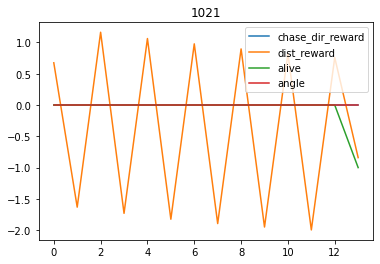

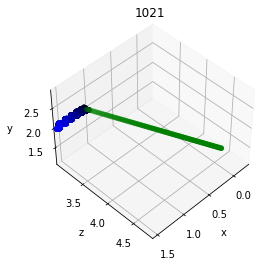

| train | E: 0 | S: 1021 | R: 0.0000 | D: 120.9 s | BR: -0.0989 | ALOSS: -756.7819 | CLOSS: 36823.5189 | TLOSS: -1.2400 | TVAL: 0.1269 | AENT: -13.7752
| eval  | E: 28 | S: 1021 | R: -6.5085
| train | E: 29 | S: 1021 | R: 21.3554 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 30 | S: 1045 | R: 15.2010 | D: 91.9 s | BR: -0.0926 | ALOSS: -693.2522 | CLOSS: 29976.4797 | TLOSS: -1.0354 | TVAL: 0.1282 | AENT: -12.0764
| train | E: 31 | S: 1074 | R: 0.1793 | D: 69.2 s | BR: -0.0762 | ALOSS: -643.2552 | CLOSS: 28848.0352 | TLOSS: -0.9345 | TVAL: 0.1290 | AENT: -11.2423
| train | E: 32 | S: 1100 | R: -9.1379 | D: 64.4 s | BR: -0.0867 | ALOSS: -604.0833 | CLOSS: 23471.0320 | TLOSS: -0.9579 | TVAL: 0.1298 | AENT: -11.3790
| train | E: 33 | S: 1107 | R: 0.2183 | D: 18.3 s | BR: -0.0793 | ALOSS: -590.0321 | CLOSS: 34254.5060 | TLOSS: -0.7456 | TVAL: 0.1303 | AENT: -9.7216
| train | E: 34 | S: 1131 | R: -20.8284 | D: 58.4 s | BR: 

| train | E: 79 | S: 1726 | R: -3.0364 | D: 14.8 s | BR: -0.2194 | ALOSS: -140.8473 | CLOSS: 2220.6994 | TLOSS: -0.2051 | TVAL: 0.1463 | AENT: -5.4021
| train | E: 80 | S: 1728 | R: -2.2668 | D: 07.1 s | BR: -0.3156 | ALOSS: -142.1557 | CLOSS: 3865.0129 | TLOSS: -0.2251 | TVAL: 0.1463 | AENT: -5.5383
| train | E: 81 | S: 1745 | R: 11.3280 | D: 40.5 s | BR: -0.2688 | ALOSS: -135.8589 | CLOSS: 2353.0526 | TLOSS: -0.1222 | TVAL: 0.1464 | AENT: -4.8347
| train | E: 82 | S: 1747 | R: 0.5016 | D: 07.1 s | BR: -0.0606 | ALOSS: -127.5214 | CLOSS: 1282.5937 | TLOSS: -0.1140 | TVAL: 0.1465 | AENT: -4.7781
| train | E: 83 | S: 1749 | R: -1.7244 | D: 06.9 s | BR: -0.2554 | ALOSS: -129.1976 | CLOSS: 2092.5381 | TLOSS: -0.1903 | TVAL: 0.1465 | AENT: -5.2988
| train | E: 84 | S: 1751 | R: -1.8873 | D: 07.1 s | BR: -0.2485 | ALOSS: -126.1542 | CLOSS: 1381.7468 | TLOSS: -0.1118 | TVAL: 0.1465 | AENT: -4.7629
| train | E: 85 | S: 1763 | R: -2.4405 | D: 30.2 s | BR: -0.2123 | ALOSS: -122.6561 | CLOSS: 17

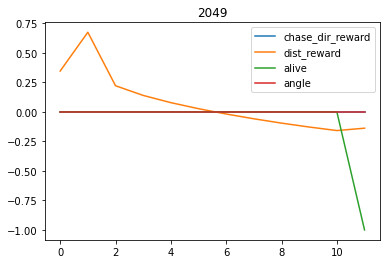

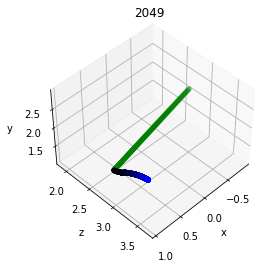

| train | E: 0 | S: 2049 | R: 0.0000 | D: 119.7 s | BR: -0.2019 | ALOSS: -34.4051 | CLOSS: 217.6159 | TLOSS: 0.1041 | TVAL: 0.1459 | AENT: -3.2869
| eval  | E: 100 | S: 2049 | R: -0.1115
| train | E: 101 | S: 2049 | R: 8.8049 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 102 | S: 2068 | R: 26.8824 | D: 78.3 s | BR: -0.1535 | ALOSS: -29.9351 | CLOSS: 160.2632 | TLOSS: 0.1187 | TVAL: 0.1458 | AENT: -3.1856
| train | E: 103 | S: 2119 | R: -20.8436 | D: 120.0 s | BR: -0.1503 | ALOSS: -26.9320 | CLOSS: 142.9429 | TLOSS: 0.0829 | TVAL: 0.1456 | AENT: -3.4305
| train | E: 104 | S: 2170 | R: -13.3255 | D: 120.4 s | BR: -0.1678 | ALOSS: -24.9027 | CLOSS: 119.3630 | TLOSS: 0.0615 | TVAL: 0.1454 | AENT: -3.5767
| train | E: 105 | S: 2183 | R: 4.5583 | D: 32.2 s | BR: -0.1557 | ALOSS: -23.7736 | CLOSS: 89.1689 | TLOSS: 0.0664 | TVAL: 0.1453 | AENT: -3.5429
| train | E: 106 | S: 2234 | R: -1.7427 | D: 120.3 s | BR: -0.1466 | ALOS

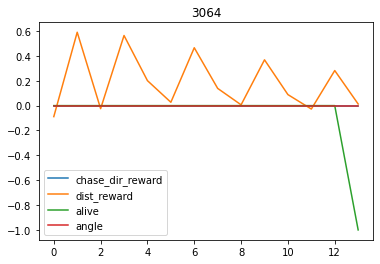

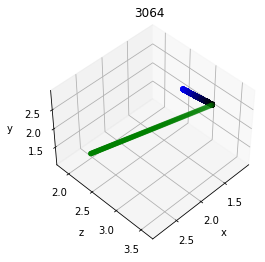

| train | E: 0 | S: 3064 | R: 0.0000 | D: 66.6 s | BR: -0.1149 | ALOSS: -10.1800 | CLOSS: 19.5958 | TLOSS: 0.3527 | TVAL: 0.1312 | AENT: -1.3120
| eval  | E: 130 | S: 3064 | R: 1.6039
| train | E: 131 | S: 3064 | R: 4.2612 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 132 | S: 3115 | R: 14.1004 | D: 153.5 s | BR: -0.0932 | ALOSS: -10.5345 | CLOSS: 18.6664 | TLOSS: 0.3504 | TVAL: 0.1302 | AENT: -1.3078
| train | E: 133 | S: 3166 | R: 14.7815 | D: 120.1 s | BR: -0.0924 | ALOSS: -10.9522 | CLOSS: 19.4309 | TLOSS: 0.3381 | TVAL: 0.1288 | AENT: -1.3763
| train | E: 134 | S: 3198 | R: 29.4765 | D: 78.0 s | BR: -0.0848 | ALOSS: -11.3250 | CLOSS: 19.7398 | TLOSS: 0.3487 | TVAL: 0.1278 | AENT: -1.2716
| train | E: 135 | S: 3213 | R: -23.7092 | D: 37.2 s | BR: -0.0690 | ALOSS: -11.1635 | CLOSS: 19.9313 | TLOSS: 0.3454 | TVAL: 0.1272 | AENT: -1.2846
| train | E: 136 | S: 3264 | R: 13.0190 | D: 120.1 s | BR: -0.0789 | ALOSS: -11

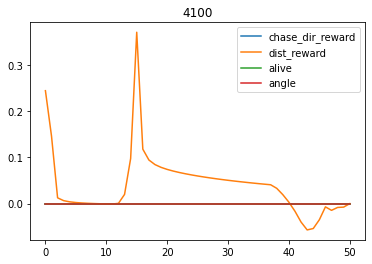

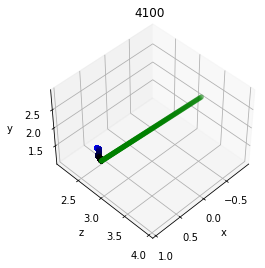

| train | E: 0 | S: 4100 | R: 0.0000 | D: 120.0 s | BR: -0.0514 | ALOSS: -7.5850 | CLOSS: 10.0034 | TLOSS: 0.2655 | TVAL: 0.1073 | AENT: -1.5254
| eval  | E: 155 | S: 4100 | R: 2.0687
| train | E: 156 | S: 4100 | R: 1.7325 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 157 | S: 4113 | R: 10.3136 | D: 146.8 s | BR: -0.0270 | ALOSS: -7.6304 | CLOSS: 9.8323 | TLOSS: 0.2724 | TVAL: 0.1066 | AENT: -1.4440
| train | E: 158 | S: 4164 | R: 34.4820 | D: 121.1 s | BR: -0.0309 | ALOSS: -7.3703 | CLOSS: 9.4804 | TLOSS: 0.2691 | TVAL: 0.1059 | AENT: -1.4583
| train | E: 159 | S: 4177 | R: 12.4839 | D: 33.4 s | BR: 0.0071 | ALOSS: -7.4284 | CLOSS: 8.7000 | TLOSS: 0.2679 | TVAL: 0.1052 | AENT: -1.4524
| train | E: 160 | S: 4228 | R: -21.7308 | D: 120.6 s | BR: -0.0010 | ALOSS: -7.1021 | CLOSS: 9.8125 | TLOSS: 0.2650 | TVAL: 0.1045 | AENT: -1.4632
| train | E: 161 | S: 4241 | R: -2.6395 | D: 34.5 s | BR: -0.0291 | ALOSS: -6.3778 | CL

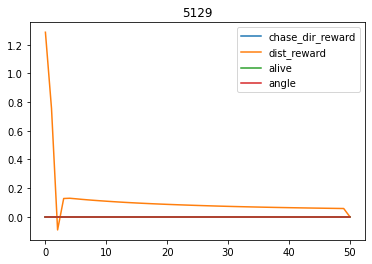

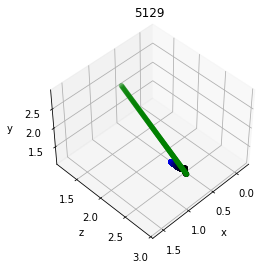

| train | E: 0 | S: 5129 | R: 0.0000 | D: 120.4 s | BR: 0.0462 | ALOSS: -3.9462 | CLOSS: 4.7814 | TLOSS: 0.2391 | TVAL: 0.0854 | AENT: -1.2015
| eval  | E: 185 | S: 5129 | R: 5.8400
| train | E: 186 | S: 5129 | R: -7.3359 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 187 | S: 5149 | R: -11.7394 | D: 167.6 s | BR: 0.0647 | ALOSS: -3.6352 | CLOSS: 4.8196 | TLOSS: 0.2307 | TVAL: 0.0847 | AENT: -1.2772
| train | E: 188 | S: 5191 | R: 22.5849 | D: 100.4 s | BR: 0.0487 | ALOSS: -3.4755 | CLOSS: 4.6290 | TLOSS: 0.2329 | TVAL: 0.0841 | AENT: -1.2320
| train | E: 189 | S: 5242 | R: 25.1208 | D: 120.6 s | BR: 0.0553 | ALOSS: -3.5003 | CLOSS: 4.3937 | TLOSS: 0.2332 | TVAL: 0.0832 | AENT: -1.1981
| train | E: 190 | S: 5266 | R: -1.8362 | D: 58.9 s | BR: 0.0531 | ALOSS: -3.6967 | CLOSS: 4.4069 | TLOSS: 0.2322 | TVAL: 0.0825 | AENT: -1.1858
| train | E: 191 | S: 5313 | R: 11.8617 | D: 110.1 s | BR: 0.0388 | ALOSS: -3.5072 | CLOSS:

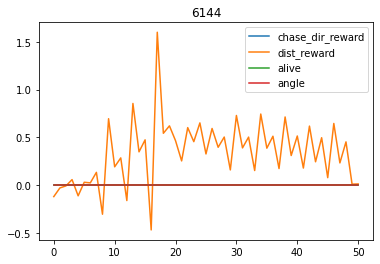

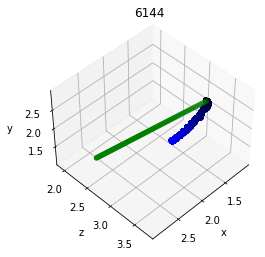

| train | E: 0 | S: 6144 | R: 0.0000 | D: 123.6 s | BR: 0.0405 | ALOSS: -2.4171 | CLOSS: 4.1345 | TLOSS: 0.1834 | TVAL: 0.0680 | AENT: -1.3023
| eval  | E: 217 | S: 6144 | R: 17.1062
| train | E: 218 | S: 6144 | R: 0.2059 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 219 | S: 6195 | R: 13.1278 | D: 238.3 s | BR: 0.0578 | ALOSS: -2.3255 | CLOSS: 3.9374 | TLOSS: 0.1773 | TVAL: 0.0672 | AENT: -1.3634
| train | E: 220 | S: 6246 | R: -4.4546 | D: 119.2 s | BR: 0.0668 | ALOSS: -2.1995 | CLOSS: 3.8570 | TLOSS: 0.1758 | TVAL: 0.0665 | AENT: -1.3566
| train | E: 221 | S: 6253 | R: 2.5645 | D: 19.3 s | BR: 0.0588 | ALOSS: -2.8454 | CLOSS: 4.4895 | TLOSS: 0.1637 | TVAL: 0.0661 | AENT: -1.5228
| train | E: 222 | S: 6304 | R: 28.5877 | D: 120.7 s | BR: 0.0728 | ALOSS: -2.6416 | CLOSS: 3.9874 | TLOSS: 0.1697 | TVAL: 0.0657 | AENT: -1.4165
| train | E: 223 | S: 6355 | R: 2.0354 | D: 125.9 s | BR: 0.0500 | ALOSS: -2.3029 | CLOSS: 3.

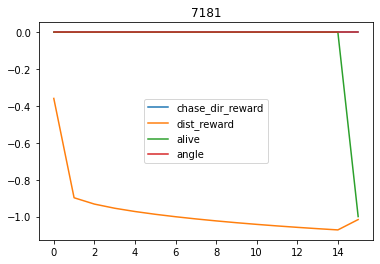

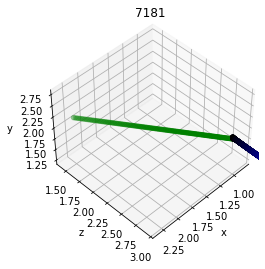

| train | E: 0 | S: 7181 | R: 0.0000 | D: 119.3 s | BR: 0.0898 | ALOSS: -3.3065 | CLOSS: 4.9257 | TLOSS: 0.1147 | TVAL: 0.0551 | AENT: -1.9175
| eval  | E: 245 | S: 7181 | R: -16.4803
| train | E: 246 | S: 7181 | R: 4.2430 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 247 | S: 7204 | R: 3.4760 | D: 95.5 s | BR: 0.0912 | ALOSS: -2.9927 | CLOSS: 4.8631 | TLOSS: 0.1192 | TVAL: 0.0547 | AENT: -1.8194
| train | E: 248 | S: 7255 | R: 31.6473 | D: 123.8 s | BR: 0.0887 | ALOSS: -2.7936 | CLOSS: 4.6669 | TLOSS: 0.1154 | TVAL: 0.0543 | AENT: -1.8749
| train | E: 249 | S: 7306 | R: 30.4663 | D: 120.3 s | BR: 0.0767 | ALOSS: -2.7189 | CLOSS: 4.4120 | TLOSS: 0.1141 | TVAL: 0.0538 | AENT: -1.8788
| train | E: 250 | S: 7357 | R: -0.8701 | D: 123.9 s | BR: 0.0859 | ALOSS: -3.3281 | CLOSS: 4.9582 | TLOSS: 0.1094 | TVAL: 0.0533 | AENT: -1.9455
| train | E: 251 | S: 7366 | R: 5.1546 | D: 24.2 s | BR: 0.1215 | ALOSS: -3.2128 | CLOSS: 5.

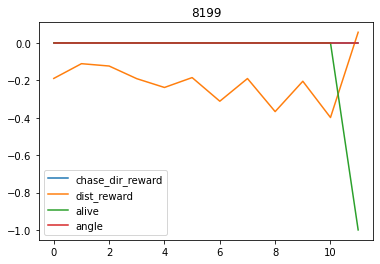

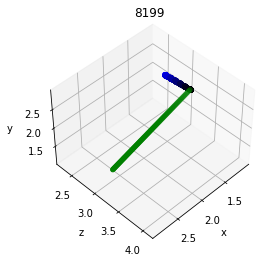

| train | E: 0 | S: 8199 | R: 0.0000 | D: 120.2 s | BR: 0.1122 | ALOSS: -3.4536 | CLOSS: 5.8862 | TLOSS: 0.0730 | TVAL: 0.0458 | AENT: -2.4060
| eval  | E: 276 | S: 8199 | R: -3.4575
| train | E: 277 | S: 8199 | R: 0.4832 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 278 | S: 8226 | R: -14.0724 | D: 96.2 s | BR: 0.1004 | ALOSS: -2.8658 | CLOSS: 5.7561 | TLOSS: 0.0702 | TVAL: 0.0455 | AENT: -2.4572
| train | E: 279 | S: 8253 | R: 16.4703 | D: 65.5 s | BR: 0.1385 | ALOSS: -3.6541 | CLOSS: 5.7134 | TLOSS: 0.0748 | TVAL: 0.0453 | AENT: -2.3504
| train | E: 280 | S: 8269 | R: -3.8421 | D: 40.2 s | BR: 0.1425 | ALOSS: -5.0755 | CLOSS: 6.8042 | TLOSS: 0.0666 | TVAL: 0.0452 | AENT: -2.5263
| train | E: 281 | S: 8317 | R: 12.0959 | D: 114.2 s | BR: 0.1001 | ALOSS: -4.9984 | CLOSS: 6.9534 | TLOSS: 0.0698 | TVAL: 0.0449 | AENT: -2.4458
| train | E: 282 | S: 8368 | R: 13.4064 | D: 124.9 s | BR: 0.1278 | ALOSS: -3.9568 | CLOSS: 6

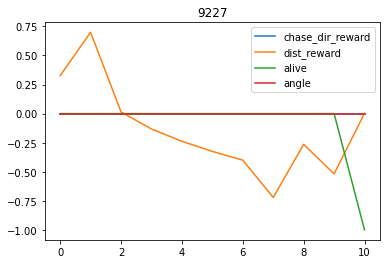

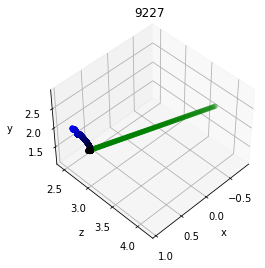

| train | E: 0 | S: 9227 | R: 0.0000 | D: 120.6 s | BR: 0.1225 | ALOSS: -4.3262 | CLOSS: 6.9303 | TLOSS: 0.0418 | TVAL: 0.0395 | AENT: -2.9424
| eval  | E: 307 | S: 9227 | R: -2.5584
| train | E: 308 | S: 9227 | R: -0.3181 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 309 | S: 9256 | R: -27.2537 | D: 95.6 s | BR: 0.1101 | ALOSS: -3.9568 | CLOSS: 7.1973 | TLOSS: 0.0381 | TVAL: 0.0393 | AENT: -3.0292
| train | E: 310 | S: 9307 | R: 7.6292 | D: 120.3 s | BR: 0.1017 | ALOSS: -4.0343 | CLOSS: 7.6976 | TLOSS: 0.0399 | TVAL: 0.0391 | AENT: -2.9791
| train | E: 311 | S: 9347 | R: -18.5048 | D: 95.9 s | BR: 0.1129 | ALOSS: -4.5627 | CLOSS: 8.1330 | TLOSS: 0.0444 | TVAL: 0.0388 | AENT: -2.8570
| train | E: 312 | S: 9398 | R: 18.5405 | D: 120.1 s | BR: 0.1043 | ALOSS: -3.8581 | CLOSS: 7.3401 | TLOSS: 0.0383 | TVAL: 0.0386 | AENT: -3.0071
| train | E: 313 | S: 9430 | R: 10.9105 | D: 78.7 s | BR: 0.0654 | ALOSS: -3.2855 | CLOSS: 

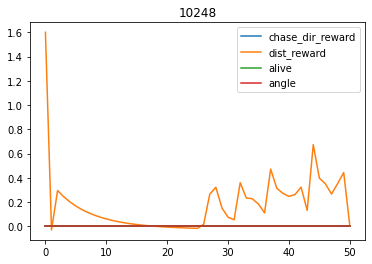

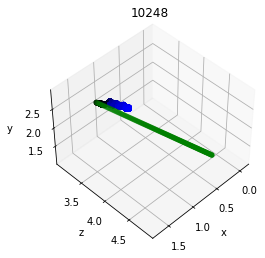

| train | E: 0 | S: 10248 | R: 0.0000 | D: 121.4 s | BR: 0.1315 | ALOSS: -5.6162 | CLOSS: 9.5843 | TLOSS: 0.0263 | TVAL: 0.0341 | AENT: -3.2287
| eval  | E: 336 | S: 10248 | R: 9.5702
| train | E: 337 | S: 10248 | R: 10.5943 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 338 | S: 10299 | R: 26.7577 | D: 235.1 s | BR: 0.1113 | ALOSS: -4.7092 | CLOSS: 8.9400 | TLOSS: 0.0229 | TVAL: 0.0339 | AENT: -3.3244
| train | E: 339 | S: 10350 | R: -20.1054 | D: 123.9 s | BR: 0.1363 | ALOSS: -6.2475 | CLOSS: 9.0225 | TLOSS: 0.0191 | TVAL: 0.0337 | AENT: -3.4339
| train | E: 340 | S: 10401 | R: 12.1108 | D: 121.3 s | BR: 0.1261 | ALOSS: -4.4699 | CLOSS: 8.7618 | TLOSS: 0.0173 | TVAL: 0.0335 | AENT: -3.4838
| train | E: 341 | S: 10430 | R: -4.7471 | D: 69.5 s | BR: 0.1373 | ALOSS: -6.5996 | CLOSS: 10.8290 | TLOSS: 0.0199 | TVAL: 0.0334 | AENT: -3.4051
| train | E: 342 | S: 10455 | R: 0.3494 | D: 60.7 s | BR: 0.1021 | ALOSS: -4.5059 |

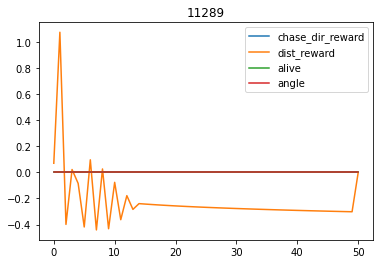

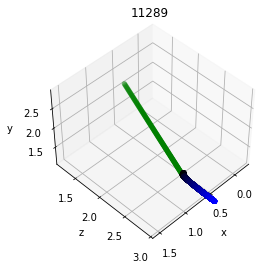

| train | E: 0 | S: 11289 | R: 0.0000 | D: 120.1 s | BR: 0.1294 | ALOSS: -5.9191 | CLOSS: 10.4311 | TLOSS: 0.0073 | TVAL: 0.0312 | AENT: -3.7649
| eval  | E: 364 | S: 11289 | R: -11.3501
| train | E: 365 | S: 11289 | R: 31.2512 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 366 | S: 11307 | R: 3.8052 | D: 158.5 s | BR: 0.1234 | ALOSS: -7.1453 | CLOSS: 10.8942 | TLOSS: 0.0019 | TVAL: 0.0311 | AENT: -3.9385
| train | E: 367 | S: 11334 | R: -11.0278 | D: 64.5 s | BR: 0.1594 | ALOSS: -8.1486 | CLOSS: 13.4566 | TLOSS: 0.0031 | TVAL: 0.0311 | AENT: -3.9014
| train | E: 368 | S: 11380 | R: 22.2070 | D: 113.0 s | BR: 0.1369 | ALOSS: -6.5492 | CLOSS: 10.9069 | TLOSS: 0.0029 | TVAL: 0.0310 | AENT: -3.9061
| train | E: 369 | S: 11431 | R: 7.4492 | D: 121.2 s | BR: 0.1336 | ALOSS: -6.0053 | CLOSS: 10.8123 | TLOSS: 0.0019 | TVAL: 0.0310 | AENT: -3.9374
| train | E: 370 | S: 11482 | R: 8.7857 | D: 123.3 s | BR: 0.1106 | ALOSS: -5.5

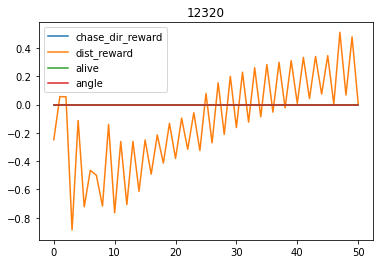

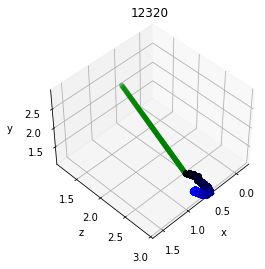

| train | E: 0 | S: 12320 | R: 0.0000 | D: 123.1 s | BR: 0.1385 | ALOSS: -7.6630 | CLOSS: 11.7291 | TLOSS: 0.0027 | TVAL: 0.0304 | AENT: -3.9095
| eval  | E: 393 | S: 12320 | R: -5.8728
| train | E: 394 | S: 12320 | R: 8.3460 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 395 | S: 12340 | R: 4.3803 | D: 163.8 s | BR: 0.1413 | ALOSS: -7.6942 | CLOSS: 13.7455 | TLOSS: 0.0026 | TVAL: 0.0303 | AENT: -3.9137
| train | E: 396 | S: 12391 | R: -5.7162 | D: 121.1 s | BR: 0.1185 | ALOSS: -5.9233 | CLOSS: 11.1824 | TLOSS: 0.0077 | TVAL: 0.0302 | AENT: -3.7439
| train | E: 397 | S: 12400 | R: 5.2579 | D: 25.5 s | BR: 0.1207 | ALOSS: -7.0608 | CLOSS: 10.9614 | TLOSS: 0.0016 | TVAL: 0.0302 | AENT: -3.9485
| train | E: 398 | S: 12409 | R: -5.3521 | D: 23.6 s | BR: 0.1142 | ALOSS: -6.2001 | CLOSS: 9.1391 | TLOSS: -0.0036 | TVAL: 0.0301 | AENT: -4.1182
| train | E: 399 | S: 12460 | R: 18.7436 | D: 125.3 s | BR: 0.1333 | ALOSS: -7.4209

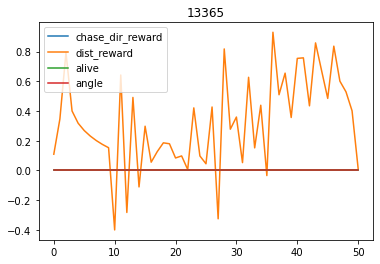

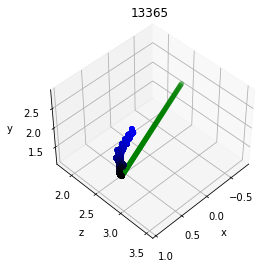

| train | E: 0 | S: 13365 | R: 0.0000 | D: 124.5 s | BR: 0.1477 | ALOSS: -11.5893 | CLOSS: 13.9625 | TLOSS: 0.0023 | TVAL: 0.0286 | AENT: -3.9206
| eval  | E: 420 | S: 13365 | R: 16.5166
| train | E: 421 | S: 13365 | R: 26.9894 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 422 | S: 13379 | R: 7.6595 | D: 153.5 s | BR: 0.1649 | ALOSS: -10.1099 | CLOSS: 16.5377 | TLOSS: -0.0049 | TVAL: 0.0286 | AENT: -4.1729
| train | E: 423 | S: 13393 | R: -2.4825 | D: 36.0 s | BR: 0.1394 | ALOSS: -8.5017 | CLOSS: 11.4692 | TLOSS: -0.0132 | TVAL: 0.0286 | AENT: -4.4610
| train | E: 424 | S: 13409 | R: 5.0627 | D: 41.4 s | BR: 0.1368 | ALOSS: -8.1069 | CLOSS: 11.6601 | TLOSS: -0.0066 | TVAL: 0.0287 | AENT: -4.2289
| train | E: 425 | S: 13460 | R: 24.1408 | D: 121.4 s | BR: 0.1537 | ALOSS: -8.9639 | CLOSS: 12.0840 | TLOSS: -0.0006 | TVAL: 0.0287 | AENT: -4.0213
| train | E: 426 | S: 13511 | R: 20.1771 | D: 120.4 s | BR: 0.1476 | ALOSS: 

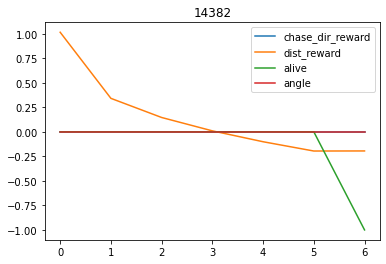

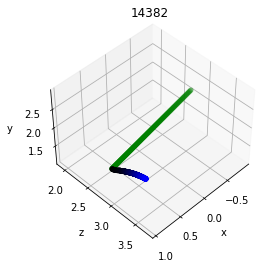

| train | E: 0 | S: 14382 | R: 0.0000 | D: 49.0 s | BR: 0.1627 | ALOSS: -11.6372 | CLOSS: 14.2754 | TLOSS: -0.0002 | TVAL: 0.0282 | AENT: -4.0063
| eval  | E: 452 | S: 14382 | R: 0.0189
| train | E: 453 | S: 14382 | R: 3.2493 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 454 | S: 14394 | R: 3.6036 | D: 50.6 s | BR: 0.1424 | ALOSS: -13.5579 | CLOSS: 15.9128 | TLOSS: 0.0013 | TVAL: 0.0282 | AENT: -3.9555
| train | E: 455 | S: 14425 | R: 18.6400 | D: 75.8 s | BR: 0.1420 | ALOSS: -10.3828 | CLOSS: 12.3760 | TLOSS: 0.0005 | TVAL: 0.0282 | AENT: -3.9838
| train | E: 456 | S: 14476 | R: -7.1376 | D: 121.3 s | BR: 0.1529 | ALOSS: -10.7529 | CLOSS: 13.6694 | TLOSS: -0.0037 | TVAL: 0.0282 | AENT: -4.1302
| train | E: 457 | S: 14527 | R: 18.9929 | D: 120.4 s | BR: 0.1558 | ALOSS: -11.6801 | CLOSS: 14.0441 | TLOSS: 0.0003 | TVAL: 0.0283 | AENT: -3.9898
| train | E: 458 | S: 14578 | R: 8.5157 | D: 121.0 s | BR: 0.1678 | ALOSS: -1

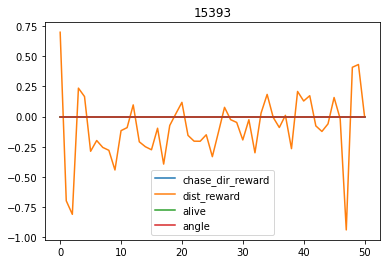

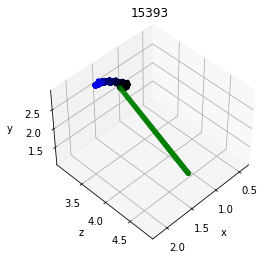

| train | E: 0 | S: 15393 | R: 0.0000 | D: 105.9 s | BR: 0.1922 | ALOSS: -9.1954 | CLOSS: 12.4598 | TLOSS: 0.0053 | TVAL: 0.0316 | AENT: -3.8312
| eval  | E: 480 | S: 15393 | R: -4.7032
| train | E: 481 | S: 15393 | R: 13.5169 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 482 | S: 15402 | R: -4.1721 | D: 140.6 s | BR: 0.1557 | ALOSS: -12.4565 | CLOSS: 15.9888 | TLOSS: 0.0070 | TVAL: 0.0315 | AENT: -3.7770
| train | E: 483 | S: 15436 | R: -9.4926 | D: 84.5 s | BR: 0.1850 | ALOSS: -13.6886 | CLOSS: 16.3272 | TLOSS: -0.0069 | TVAL: 0.0315 | AENT: -4.2181
| train | E: 484 | S: 15487 | R: 30.8308 | D: 120.1 s | BR: 0.1452 | ALOSS: -10.9423 | CLOSS: 12.6708 | TLOSS: -0.0079 | TVAL: 0.0318 | AENT: -4.2507
| train | E: 485 | S: 15529 | R: 7.9278 | D: 103.2 s | BR: 0.1874 | ALOSS: -13.2408 | CLOSS: 15.8334 | TLOSS: 0.0020 | TVAL: 0.0318 | AENT: -3.9359
| train | E: 486 | S: 15555 | R: 27.6191 | D: 63.4 s | BR: 0.1570 | ALOSS:

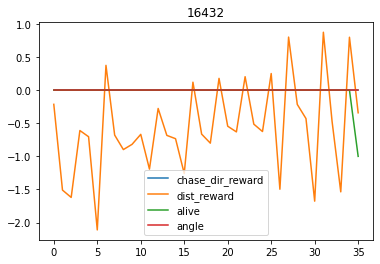

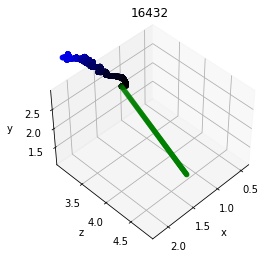

| train | E: 0 | S: 16432 | R: 0.0000 | D: 121.1 s | BR: 0.1617 | ALOSS: -12.5401 | CLOSS: 14.5676 | TLOSS: 0.0022 | TVAL: 0.0313 | AENT: -3.9293
| eval  | E: 507 | S: 16432 | R: -21.3251
| train | E: 508 | S: 16432 | R: 17.0702 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 509 | S: 16483 | R: 33.8313 | D: 205.4 s | BR: 0.1725 | ALOSS: -12.3426 | CLOSS: 14.2225 | TLOSS: -0.0056 | TVAL: 0.0314 | AENT: -4.1775
| train | E: 510 | S: 16534 | R: 12.8087 | D: 122.2 s | BR: 0.1749 | ALOSS: -10.9325 | CLOSS: 15.6713 | TLOSS: -0.0017 | TVAL: 0.0315 | AENT: -4.0536
| train | E: 511 | S: 16552 | R: 12.3880 | D: 44.2 s | BR: 0.1751 | ALOSS: -11.3426 | CLOSS: 12.8694 | TLOSS: -0.0031 | TVAL: 0.0316 | AENT: -4.0991
| train | E: 512 | S: 16566 | R: 4.2148 | D: 35.7 s | BR: 0.1818 | ALOSS: -13.0500 | CLOSS: 15.1944 | TLOSS: -0.0086 | TVAL: 0.0316 | AENT: -4.2729
| train | E: 513 | S: 16575 | R: 2.8348 | D: 24.0 s | BR: 0.1933 | ALOS

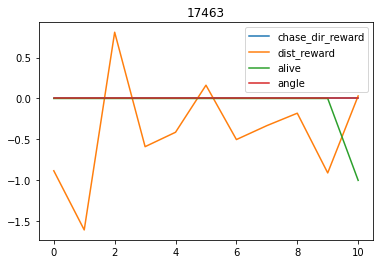

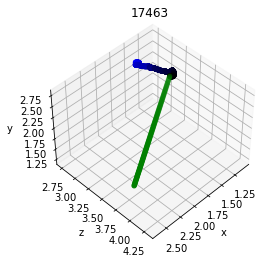

| train | E: 0 | S: 17463 | R: 0.0000 | D: 121.3 s | BR: 0.1845 | ALOSS: -11.1052 | CLOSS: 12.6554 | TLOSS: 0.0120 | TVAL: 0.0337 | AENT: -3.6441
| eval  | E: 537 | S: 17463 | R: -5.4103
| train | E: 538 | S: 17463 | R: -23.0189 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 539 | S: 17514 | R: 20.6399 | D: 152.0 s | BR: 0.1751 | ALOSS: -10.0106 | CLOSS: 12.0443 | TLOSS: 0.0057 | TVAL: 0.0333 | AENT: -3.8288
| train | E: 540 | S: 17535 | R: -5.2900 | D: 51.7 s | BR: 0.1919 | ALOSS: -12.4232 | CLOSS: 12.2709 | TLOSS: 0.0058 | TVAL: 0.0331 | AENT: -3.8251
| train | E: 541 | S: 17548 | R: -3.2091 | D: 32.9 s | BR: 0.1679 | ALOSS: -12.1750 | CLOSS: 17.6870 | TLOSS: 0.0005 | TVAL: 0.0330 | AENT: -3.9850
| train | E: 542 | S: 17599 | R: 18.4495 | D: 120.6 s | BR: 0.1962 | ALOSS: -12.2696 | CLOSS: 12.2058 | TLOSS: 0.0074 | TVAL: 0.0329 | AENT: -3.7763
| train | E: 543 | S: 17617 | R: 3.8223 | D: 44.1 s | BR: 0.1713 | ALOSS: 

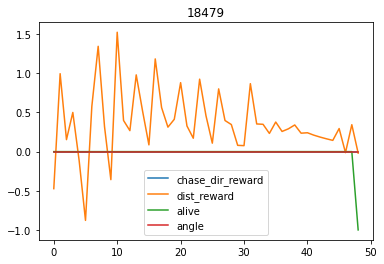

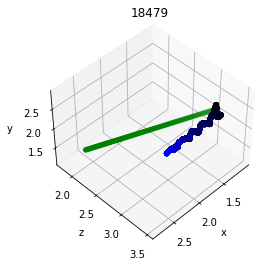

| train | E: 0 | S: 18479 | R: 0.0000 | D: 121.5 s | BR: 0.1854 | ALOSS: -11.3623 | CLOSS: 10.8702 | TLOSS: -0.0029 | TVAL: 0.0302 | AENT: -4.0977
| eval  | E: 564 | S: 18479 | R: 16.7447
| train | E: 565 | S: 18479 | R: -2.6460 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 566 | S: 18506 | R: 18.1976 | D: 176.4 s | BR: 0.1645 | ALOSS: -9.6540 | CLOSS: 11.7234 | TLOSS: -0.0081 | TVAL: 0.0303 | AENT: -4.2690
| train | E: 567 | S: 18557 | R: 24.9210 | D: 120.0 s | BR: 0.1746 | ALOSS: -9.6825 | CLOSS: 10.4712 | TLOSS: 0.0093 | TVAL: 0.0303 | AENT: -3.6921
| train | E: 568 | S: 18563 | R: 6.7065 | D: 16.4 s | BR: 0.2009 | ALOSS: -11.8757 | CLOSS: 13.5088 | TLOSS: 0.0165 | TVAL: 0.0301 | AENT: -3.4506
| train | E: 569 | S: 18614 | R: 22.1350 | D: 121.1 s | BR: 0.1846 | ALOSS: -10.6843 | CLOSS: 11.7526 | TLOSS: 0.0053 | TVAL: 0.0299 | AENT: -3.8248
| train | E: 570 | S: 18620 | R: 2.4615 | D: 16.5 s | BR: 0.2211 | ALOSS: -

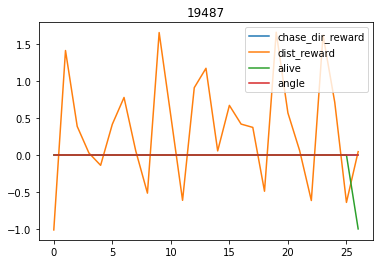

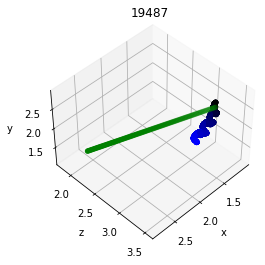

| train | E: 0 | S: 19487 | R: 0.0000 | D: 93.2 s | BR: 0.1969 | ALOSS: -9.2398 | CLOSS: 9.6575 | TLOSS: 0.0027 | TVAL: 0.0293 | AENT: -3.9071
| eval  | E: 596 | S: 19487 | R: 8.5209
| train | E: 597 | S: 19487 | R: 0.7714 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 598 | S: 19538 | R: 18.9368 | D: 184.6 s | BR: 0.2007 | ALOSS: -10.2900 | CLOSS: 10.4936 | TLOSS: 0.0050 | TVAL: 0.0292 | AENT: -3.8304
| train | E: 599 | S: 19553 | R: 2.6975 | D: 39.9 s | BR: 0.2149 | ALOSS: -9.0917 | CLOSS: 9.6817 | TLOSS: 0.0102 | TVAL: 0.0291 | AENT: -3.6498
| train | E: 600 | S: 19563 | R: -7.4657 | D: 27.1 s | BR: 0.1934 | ALOSS: -9.0407 | CLOSS: 10.0070 | TLOSS: -0.0054 | TVAL: 0.0290 | AENT: -4.1846
| train | E: 601 | S: 19608 | R: 19.1396 | D: 110.6 s | BR: 0.1925 | ALOSS: -9.3715 | CLOSS: 9.2441 | TLOSS: 0.0026 | TVAL: 0.0290 | AENT: -3.9092
| train | E: 602 | S: 19659 | R: 9.0793 | D: 119.7 s | BR: 0.2019 | ALOSS: -9.7505 | 

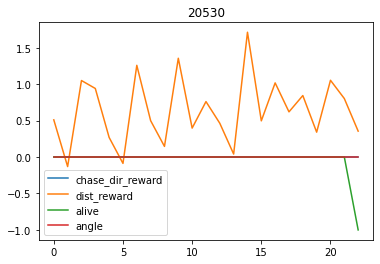

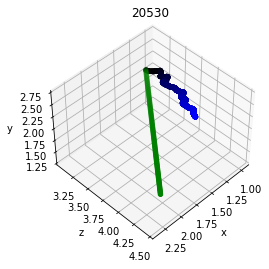

| train | E: 0 | S: 20530 | R: 0.0000 | D: 120.3 s | BR: 0.1962 | ALOSS: -8.5219 | CLOSS: 9.8047 | TLOSS: -0.0002 | TVAL: 0.0281 | AENT: -4.0065
| eval  | E: 627 | S: 20530 | R: 13.7128
| train | E: 628 | S: 20530 | R: 31.9073 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 629 | S: 20553 | R: 26.7605 | D: 111.1 s | BR: 0.1922 | ALOSS: -5.4403 | CLOSS: 8.0513 | TLOSS: -0.0013 | TVAL: 0.0281 | AENT: -4.0470
| train | E: 630 | S: 20579 | R: 15.5139 | D: 62.6 s | BR: 0.1822 | ALOSS: -7.7036 | CLOSS: 8.3148 | TLOSS: 0.0008 | TVAL: 0.0281 | AENT: -3.9716
| train | E: 631 | S: 20630 | R: 21.6700 | D: 120.0 s | BR: 0.2251 | ALOSS: -8.5256 | CLOSS: 9.1649 | TLOSS: -0.0002 | TVAL: 0.0281 | AENT: -4.0082
| train | E: 632 | S: 20681 | R: 32.1536 | D: 122.4 s | BR: 0.2019 | ALOSS: -8.5919 | CLOSS: 10.1496 | TLOSS: -0.0041 | TVAL: 0.0281 | AENT: -4.1466
| train | E: 633 | S: 20696 | R: 9.4621 | D: 38.2 s | BR: 0.2069 | ALOSS: -12.1

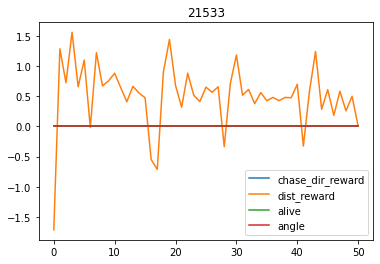

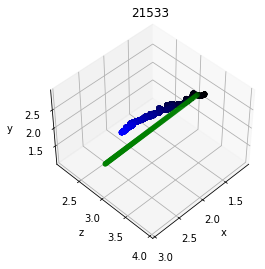

| train | E: 0 | S: 21533 | R: 0.0000 | D: 120.8 s | BR: 0.2191 | ALOSS: -8.3220 | CLOSS: 8.3606 | TLOSS: 0.0035 | TVAL: 0.0266 | AENT: -3.8700
| eval  | E: 659 | S: 21533 | R: 26.0984
| train | E: 660 | S: 21533 | R: 3.3108 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 661 | S: 21584 | R: 11.8092 | D: 237.8 s | BR: 0.2020 | ALOSS: -8.0224 | CLOSS: 8.7318 | TLOSS: -0.0023 | TVAL: 0.0265 | AENT: -4.0884
| train | E: 662 | S: 21607 | R: 16.6783 | D: 58.1 s | BR: 0.1940 | ALOSS: -6.7986 | CLOSS: 8.0691 | TLOSS: 0.0028 | TVAL: 0.0266 | AENT: -3.8956
| train | E: 663 | S: 21615 | R: -2.1146 | D: 20.6 s | BR: 0.2325 | ALOSS: -8.4104 | CLOSS: 7.4597 | TLOSS: -0.0011 | TVAL: 0.0266 | AENT: -4.0427
| train | E: 664 | S: 21666 | R: 36.5051 | D: 124.4 s | BR: 0.2089 | ALOSS: -9.0854 | CLOSS: 8.6360 | TLOSS: -0.0066 | TVAL: 0.0267 | AENT: -4.2496
| train | E: 665 | S: 21678 | R: 2.7822 | D: 30.4 s | BR: 0.1925 | ALOSS: -8.6130 |

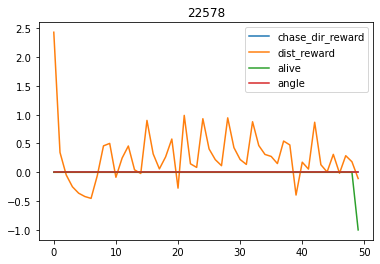

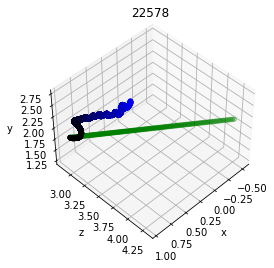

| train | E: 0 | S: 22578 | R: 0.0000 | D: 121.0 s | BR: 0.1896 | ALOSS: -7.9634 | CLOSS: 7.7759 | TLOSS: 0.0034 | TVAL: 0.0265 | AENT: -3.8712
| eval  | E: 686 | S: 22578 | R: 12.8563
| train | E: 687 | S: 22578 | R: 17.1497 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 688 | S: 22596 | R: 15.0207 | D: 162.8 s | BR: 0.2293 | ALOSS: -8.7928 | CLOSS: 7.7736 | TLOSS: -0.0068 | TVAL: 0.0265 | AENT: -4.2582
| train | E: 689 | S: 22607 | R: -5.3141 | D: 29.9 s | BR: 0.1939 | ALOSS: -7.7559 | CLOSS: 7.1979 | TLOSS: -0.0053 | TVAL: 0.0266 | AENT: -4.2012
| train | E: 690 | S: 22617 | R: -0.0337 | D: 27.1 s | BR: 0.1987 | ALOSS: -8.8787 | CLOSS: 9.2259 | TLOSS: -0.0013 | TVAL: 0.0266 | AENT: -4.0504
| train | E: 691 | S: 22668 | R: 27.9105 | D: 125.5 s | BR: 0.2137 | ALOSS: -7.7060 | CLOSS: 8.6812 | TLOSS: -0.0021 | TVAL: 0.0267 | AENT: -4.0795
| train | E: 692 | S: 22719 | R: 30.7491 | D: 123.8 s | BR: 0.2120 | ALOSS: -10.4

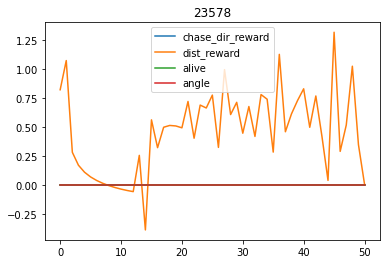

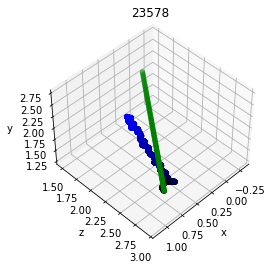

| train | E: 0 | S: 23578 | R: 0.0000 | D: 40.7 s | BR: 0.1759 | ALOSS: -5.0255 | CLOSS: 6.5890 | TLOSS: 0.0003 | TVAL: 0.0270 | AENT: -3.9899
| eval  | E: 711 | S: 23578 | R: 23.4433
| train | E: 712 | S: 23578 | R: 0.7664 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 713 | S: 23610 | R: 8.5331 | D: 193.4 s | BR: 0.2295 | ALOSS: -8.2275 | CLOSS: 8.8445 | TLOSS: 0.0054 | TVAL: 0.0270 | AENT: -3.7996
| train | E: 714 | S: 23631 | R: 2.9325 | D: 54.5 s | BR: 0.2213 | ALOSS: -7.1532 | CLOSS: 7.3402 | TLOSS: 0.0082 | TVAL: 0.0269 | AENT: -3.6953
| train | E: 715 | S: 23682 | R: 10.3112 | D: 120.3 s | BR: 0.2377 | ALOSS: -7.4956 | CLOSS: 8.8449 | TLOSS: -0.0042 | TVAL: 0.0269 | AENT: -4.1581
| train | E: 716 | S: 23733 | R: 31.9549 | D: 124.5 s | BR: 0.2366 | ALOSS: -7.1462 | CLOSS: 8.4093 | TLOSS: -0.0036 | TVAL: 0.0270 | AENT: -4.1328
| train | E: 717 | S: 23780 | R: 2.2810 | D: 110.2 s | BR: 0.2296 | ALOSS: -9.6737 | C

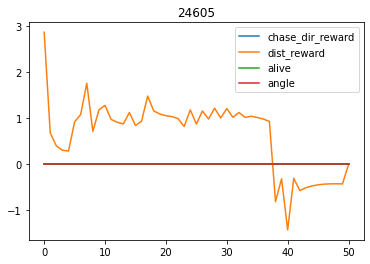

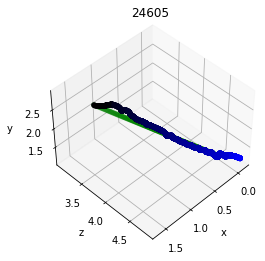

| train | E: 0 | S: 24605 | R: 0.0000 | D: 90.8 s | BR: 0.2297 | ALOSS: -9.4219 | CLOSS: 8.5053 | TLOSS: 0.0014 | TVAL: 0.0270 | AENT: -3.9476
| eval  | E: 736 | S: 24605 | R: 33.0755
| train | E: 737 | S: 24605 | R: 8.5217 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 738 | S: 24626 | R: 5.3986 | D: 169.6 s | BR: 0.2303 | ALOSS: -9.2568 | CLOSS: 7.5113 | TLOSS: -0.0010 | TVAL: 0.0270 | AENT: -4.0357
| train | E: 739 | S: 24645 | R: 0.7304 | D: 48.0 s | BR: 0.2024 | ALOSS: -7.8145 | CLOSS: 8.8377 | TLOSS: -0.0045 | TVAL: 0.0270 | AENT: -4.1672
| train | E: 740 | S: 24684 | R: 16.9234 | D: 92.7 s | BR: 0.2316 | ALOSS: -6.7408 | CLOSS: 7.3711 | TLOSS: 0.0020 | TVAL: 0.0270 | AENT: -3.9266
| train | E: 741 | S: 24704 | R: 7.2712 | D: 50.5 s | BR: 0.2263 | ALOSS: -8.8105 | CLOSS: 8.3439 | TLOSS: -0.0068 | TVAL: 0.0270 | AENT: -4.2512
| train | E: 742 | S: 24755 | R: 12.6151 | D: 120.1 s | BR: 0.2322 | ALOSS: -6.9374 | CL

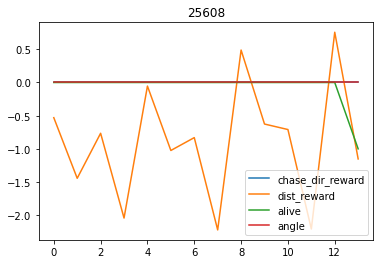

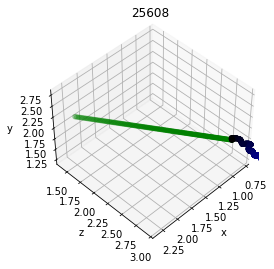

| train | E: 0 | S: 25608 | R: 0.0000 | D: 123.5 s | BR: 0.2226 | ALOSS: -8.7356 | CLOSS: 8.5106 | TLOSS: 0.0015 | TVAL: 0.0274 | AENT: -3.9465
| eval  | E: 762 | S: 25608 | R: -13.3576
| train | E: 763 | S: 25608 | R: 10.2263 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 764 | S: 25635 | R: 6.5610 | D: 102.3 s | BR: 0.2570 | ALOSS: -10.6901 | CLOSS: 10.7108 | TLOSS: 0.0016 | TVAL: 0.0274 | AENT: -3.9409
| train | E: 765 | S: 25650 | R: 11.8391 | D: 38.3 s | BR: 0.2175 | ALOSS: -12.7847 | CLOSS: 14.0449 | TLOSS: -0.0066 | TVAL: 0.0274 | AENT: -4.2401
| train | E: 766 | S: 25701 | R: 33.3805 | D: 124.2 s | BR: 0.2228 | ALOSS: -6.0508 | CLOSS: 7.8798 | TLOSS: 0.0013 | TVAL: 0.0275 | AENT: -3.9543
| train | E: 767 | S: 25731 | R: 15.1714 | D: 73.1 s | BR: 0.2434 | ALOSS: -8.9974 | CLOSS: 8.8188 | TLOSS: -0.0004 | TVAL: 0.0274 | AENT: -4.0155
| train | E: 768 | S: 25782 | R: 37.1648 | D: 124.4 s | BR: 0.2289 | ALOSS: -9.

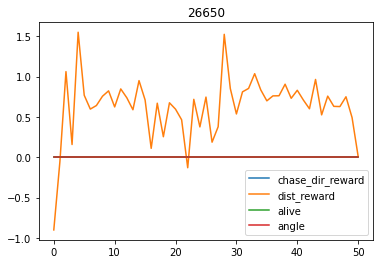

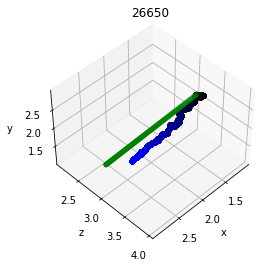

| train | E: 0 | S: 26650 | R: 0.0000 | D: 120.0 s | BR: 0.2522 | ALOSS: -8.9779 | CLOSS: 8.3618 | TLOSS: 0.0024 | TVAL: 0.0296 | AENT: -3.9192
| eval  | E: 787 | S: 26650 | R: 32.0695
| train | E: 788 | S: 26650 | R: 26.4458 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 789 | S: 26701 | R: 33.4002 | D: 239.0 s | BR: 0.2427 | ALOSS: -8.3417 | CLOSS: 8.0906 | TLOSS: -0.0082 | TVAL: 0.0297 | AENT: -4.2754
| train | E: 790 | S: 26752 | R: 28.0686 | D: 121.3 s | BR: 0.2334 | ALOSS: -7.2474 | CLOSS: 7.3984 | TLOSS: 0.0064 | TVAL: 0.0298 | AENT: -3.7853
| train | E: 791 | S: 26803 | R: 31.8504 | D: 119.8 s | BR: 0.2315 | ALOSS: -7.4761 | CLOSS: 7.6220 | TLOSS: -0.0025 | TVAL: 0.0297 | AENT: -4.0844
| train | E: 792 | S: 26841 | R: 17.8299 | D: 90.3 s | BR: 0.2437 | ALOSS: -7.8616 | CLOSS: 7.9751 | TLOSS: -0.0057 | TVAL: 0.0298 | AENT: -4.1906
| train | E: 793 | S: 26892 | R: 14.6289 | D: 121.1 s | BR: 0.2389 | ALOSS: -9.33

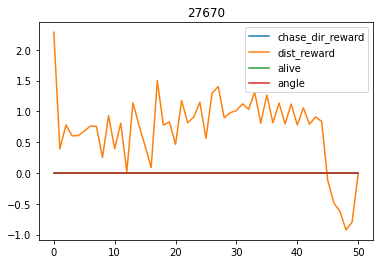

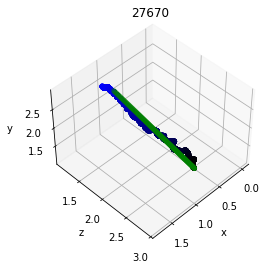

| train | E: 0 | S: 27670 | R: 0.0000 | D: 124.0 s | BR: 0.2591 | ALOSS: -7.3528 | CLOSS: 7.2924 | TLOSS: 0.0049 | TVAL: 0.0284 | AENT: -3.8261
| eval  | E: 812 | S: 27670 | R: 36.2785
| train | E: 813 | S: 27670 | R: 30.1396 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 814 | S: 27721 | R: -0.9676 | D: 233.9 s | BR: 0.2419 | ALOSS: -7.6459 | CLOSS: 7.2825 | TLOSS: 0.0024 | TVAL: 0.0282 | AENT: -3.9133
| train | E: 815 | S: 27763 | R: 24.7321 | D: 100.0 s | BR: 0.2482 | ALOSS: -6.8945 | CLOSS: 7.7702 | TLOSS: 0.0002 | TVAL: 0.0281 | AENT: -3.9928
| train | E: 816 | S: 27814 | R: 30.9975 | D: 123.9 s | BR: 0.2658 | ALOSS: -8.5512 | CLOSS: 7.4283 | TLOSS: 0.0064 | TVAL: 0.0280 | AENT: -3.7699
| train | E: 817 | S: 27865 | R: 27.8384 | D: 121.9 s | BR: 0.2528 | ALOSS: -7.9130 | CLOSS: 8.1314 | TLOSS: -0.0025 | TVAL: 0.0279 | AENT: -4.0886
| train | E: 818 | S: 27916 | R: 29.0877 | D: 125.1 s | BR: 0.2542 | ALOSS: -7.094

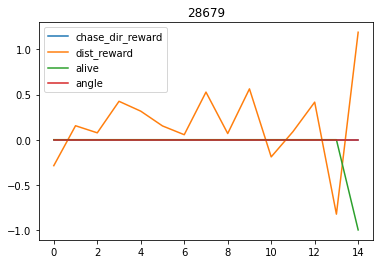

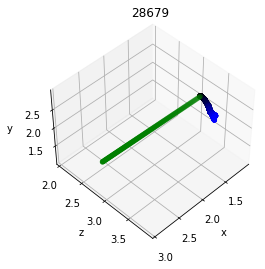

| train | E: 0 | S: 28679 | R: 0.0000 | D: 121.3 s | BR: 0.2577 | ALOSS: -7.8741 | CLOSS: 7.6264 | TLOSS: -0.0097 | TVAL: 0.0279 | AENT: -4.3475
| eval  | E: 835 | S: 28679 | R: 1.7323
| train | E: 836 | S: 28679 | R: 33.3985 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 837 | S: 28730 | R: 18.0087 | D: 156.5 s | BR: 0.2587 | ALOSS: -7.6703 | CLOSS: 7.3375 | TLOSS: 0.0007 | TVAL: 0.0282 | AENT: -3.9748
| train | E: 838 | S: 28781 | R: 31.6772 | D: 125.1 s | BR: 0.2585 | ALOSS: -7.3679 | CLOSS: 6.6662 | TLOSS: -0.0011 | TVAL: 0.0282 | AENT: -4.0388
| train | E: 839 | S: 28832 | R: 31.9569 | D: 122.0 s | BR: 0.2618 | ALOSS: -8.0472 | CLOSS: 7.2936 | TLOSS: -0.0041 | TVAL: 0.0282 | AENT: -4.1468
| train | E: 840 | S: 28877 | R: 0.9295 | D: 107.9 s | BR: 0.2503 | ALOSS: -8.3222 | CLOSS: 7.0797 | TLOSS: 0.0025 | TVAL: 0.0284 | AENT: -3.9113
| train | E: 841 | S: 28917 | R: 5.5323 | D: 95.6 s | BR: 0.2670 | ALOSS: -8.4419 

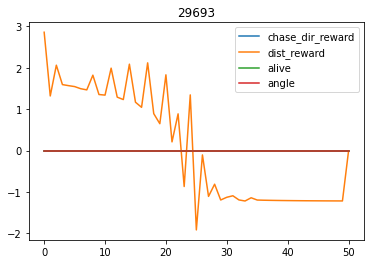

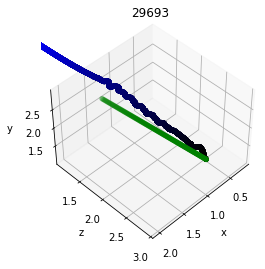

| train | E: 0 | S: 29693 | R: 0.0000 | D: 41.1 s | BR: 0.2737 | ALOSS: -8.4017 | CLOSS: 6.2522 | TLOSS: -0.0075 | TVAL: 0.0273 | AENT: -4.2748
| eval  | E: 866 | S: 29693 | R: 5.2615
| train | E: 867 | S: 29693 | R: 13.7068 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 868 | S: 29701 | R: 4.9195 | D: 137.0 s | BR: 0.2734 | ALOSS: -8.6350 | CLOSS: 8.5166 | TLOSS: -0.0085 | TVAL: 0.0274 | AENT: -4.3101
| train | E: 869 | S: 29752 | R: 29.9240 | D: 121.4 s | BR: 0.2839 | ALOSS: -7.3939 | CLOSS: 6.5388 | TLOSS: -0.0001 | TVAL: 0.0274 | AENT: -4.0025
| train | E: 870 | S: 29803 | R: 23.2874 | D: 126.5 s | BR: 0.2670 | ALOSS: -8.1388 | CLOSS: 6.8233 | TLOSS: 0.0001 | TVAL: 0.0275 | AENT: -3.9968
| train | E: 871 | S: 29854 | R: 28.5757 | D: 122.6 s | BR: 0.2559 | ALOSS: -7.7717 | CLOSS: 6.7565 | TLOSS: -0.0013 | TVAL: 0.0274 | AENT: -4.0484
| train | E: 872 | S: 29877 | R: -5.7776 | D: 59.2 s | BR: 0.2715 | ALOSS: -5.6143

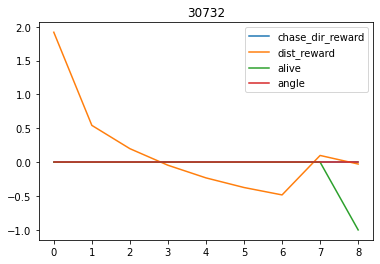

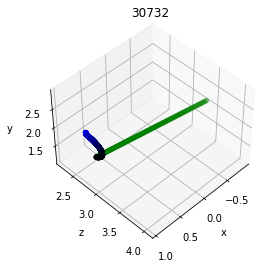

| train | E: 0 | S: 30732 | R: 0.0000 | D: 124.3 s | BR: 0.2725 | ALOSS: -8.8598 | CLOSS: 8.2151 | TLOSS: -0.0024 | TVAL: 0.0280 | AENT: -4.0839
| eval  | E: 895 | S: 30732 | R: 0.5977
| train | E: 896 | S: 30732 | R: 23.7626 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 897 | S: 30783 | R: 22.1461 | D: 146.9 s | BR: 0.2726 | ALOSS: -7.5152 | CLOSS: 6.7625 | TLOSS: 0.0009 | TVAL: 0.0282 | AENT: -3.9702
| train | E: 898 | S: 30806 | R: 4.8191 | D: 57.0 s | BR: 0.2618 | ALOSS: -7.8360 | CLOSS: 6.2075 | TLOSS: 0.0057 | TVAL: 0.0282 | AENT: -3.7976
| train | E: 899 | S: 30857 | R: 38.7663 | D: 124.6 s | BR: 0.2579 | ALOSS: -8.2962 | CLOSS: 7.7214 | TLOSS: 0.0009 | TVAL: 0.0281 | AENT: -3.9676
| train | E: 900 | S: 30870 | R: 3.2411 | D: 33.0 s | BR: 0.2697 | ALOSS: -6.8720 | CLOSS: 6.9562 | TLOSS: 0.0041 | TVAL: 0.0280 | AENT: -3.8529
| train | E: 901 | S: 30879 | R: 0.1728 | D: 25.6 s | BR: 0.2899 | ALOSS: -7.3197 | CLO

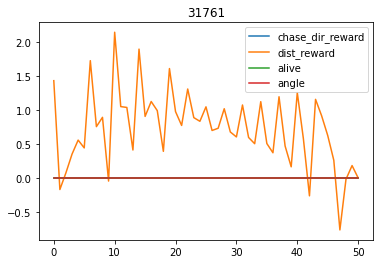

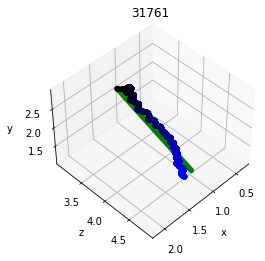

| train | E: 0 | S: 31761 | R: 0.0000 | D: 125.2 s | BR: 0.2605 | ALOSS: -7.4867 | CLOSS: 6.6926 | TLOSS: 0.0015 | TVAL: 0.0286 | AENT: -3.9490
| eval  | E: 922 | S: 31761 | R: 37.0227
| train | E: 923 | S: 31761 | R: -10.9864 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 924 | S: 31769 | R: 2.5146 | D: 134.0 s | BR: 0.2990 | ALOSS: -9.8345 | CLOSS: 6.9350 | TLOSS: -0.0014 | TVAL: 0.0285 | AENT: -4.0481
| train | E: 925 | S: 31820 | R: 34.2564 | D: 120.7 s | BR: 0.2699 | ALOSS: -8.9113 | CLOSS: 7.7473 | TLOSS: -0.0011 | TVAL: 0.0286 | AENT: -4.0384
| train | E: 926 | S: 31871 | R: 35.6784 | D: 121.5 s | BR: 0.2785 | ALOSS: -8.1212 | CLOSS: 7.2172 | TLOSS: 0.0019 | TVAL: 0.0286 | AENT: -3.9321
| train | E: 927 | S: 31894 | R: 8.2937 | D: 57.5 s | BR: 0.2710 | ALOSS: -7.2313 | CLOSS: 7.1416 | TLOSS: -0.0025 | TVAL: 0.0285 | AENT: -4.0883
| train | E: 928 | S: 31904 | R: -3.9379 | D: 27.1 s | BR: 0.3047 | ALOSS: -6.2146

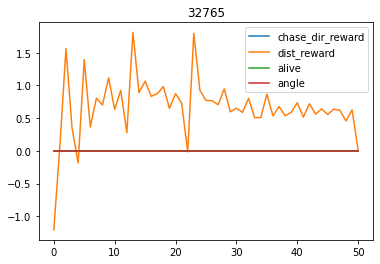

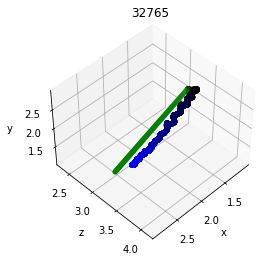

| train | E: 0 | S: 32765 | R: 0.0000 | D: 120.7 s | BR: 0.2665 | ALOSS: -6.7751 | CLOSS: 6.4166 | TLOSS: 0.0018 | TVAL: 0.0273 | AENT: -3.9338
| eval  | E: 950 | S: 32765 | R: 34.3319
| train | E: 951 | S: 32765 | R: 13.7852 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 952 | S: 32816 | R: 29.8735 | D: 234.4 s | BR: 0.2725 | ALOSS: -7.1868 | CLOSS: 6.8657 | TLOSS: -0.0008 | TVAL: 0.0272 | AENT: -4.0301
| train | E: 953 | S: 32867 | R: 17.0425 | D: 120.8 s | BR: 0.2816 | ALOSS: -6.1938 | CLOSS: 6.3713 | TLOSS: 0.0007 | TVAL: 0.0272 | AENT: -3.9750
| train | E: 954 | S: 32877 | R: -6.5540 | D: 26.1 s | BR: 0.2589 | ALOSS: -9.1660 | CLOSS: 9.8767 | TLOSS: -0.0128 | TVAL: 0.0272 | AENT: -4.4682
| train | E: 955 | S: 32911 | R: 29.2360 | D: 82.1 s | BR: 0.2669 | ALOSS: -7.5325 | CLOSS: 6.4797 | TLOSS: -0.0046 | TVAL: 0.0274 | AENT: -4.1668
| train | E: 956 | S: 32936 | R: 19.8693 | D: 60.4 s | BR: 0.2799 | ALOSS: -9.4542

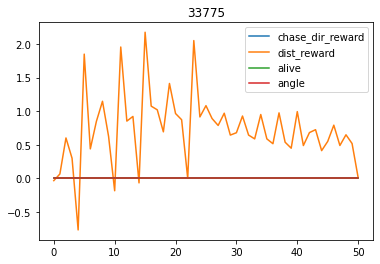

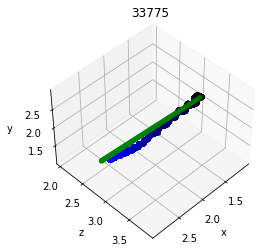

| train | E: 0 | S: 33775 | R: 0.0000 | D: 121.8 s | BR: 0.2885 | ALOSS: -6.1825 | CLOSS: 6.0902 | TLOSS: 0.0077 | TVAL: 0.0283 | AENT: -3.7284
| eval  | E: 976 | S: 33775 | R: 37.2540
| train | E: 977 | S: 33775 | R: 22.7302 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 978 | S: 33826 | R: 5.2462 | D: 234.3 s | BR: 0.2530 | ALOSS: -8.0530 | CLOSS: 7.8554 | TLOSS: -0.0053 | TVAL: 0.0282 | AENT: -4.1886
| train | E: 979 | S: 33877 | R: 32.8383 | D: 121.4 s | BR: 0.2717 | ALOSS: -5.2070 | CLOSS: 6.3138 | TLOSS: -0.0000 | TVAL: 0.0284 | AENT: -4.0011
| train | E: 980 | S: 33928 | R: 38.1108 | D: 120.1 s | BR: 0.2708 | ALOSS: -7.8519 | CLOSS: 7.3604 | TLOSS: 0.0011 | TVAL: 0.0284 | AENT: -3.9615
| train | E: 981 | S: 33936 | R: 11.1427 | D: 20.5 s | BR: 0.2918 | ALOSS: -6.9953 | CLOSS: 7.4983 | TLOSS: 0.0099 | TVAL: 0.0283 | AENT: -3.6505
| train | E: 982 | S: 33972 | R: 13.1424 | D: 87.0 s | BR: 0.2747 | ALOSS: -6.9097 

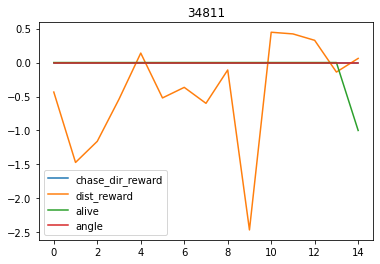

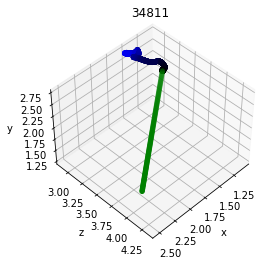

| train | E: 0 | S: 34811 | R: 0.0000 | D: 124.2 s | BR: 0.2905 | ALOSS: -6.8811 | CLOSS: 7.0200 | TLOSS: -0.0008 | TVAL: 0.0292 | AENT: -4.0283
| eval  | E: 1000 | S: 34811 | R: -7.4104
| train | E: 1001 | S: 34811 | R: 24.1597 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1002 | S: 34862 | R: 35.0663 | D: 158.9 s | BR: 0.2961 | ALOSS: -6.4038 | CLOSS: 5.9335 | TLOSS: 0.0029 | TVAL: 0.0292 | AENT: -3.9026
| train | E: 1003 | S: 34869 | R: 4.0476 | D: 18.7 s | BR: 0.3022 | ALOSS: -7.4007 | CLOSS: 7.4149 | TLOSS: -0.0086 | TVAL: 0.0291 | AENT: -4.2970
| train | E: 1004 | S: 34920 | R: 36.3544 | D: 120.3 s | BR: 0.2639 | ALOSS: -6.1981 | CLOSS: 6.3237 | TLOSS: -0.0006 | TVAL: 0.0292 | AENT: -4.0201
| train | E: 1005 | S: 34971 | R: 28.5174 | D: 121.0 s | BR: 0.2714 | ALOSS: -8.2376 | CLOSS: 7.8249 | TLOSS: -0.0065 | TVAL: 0.0293 | AENT: -4.2230
| train | E: 1006 | S: 34985 | R: 13.5789 | D: 35.4 s | BR: 0.3050 | ALOSS:

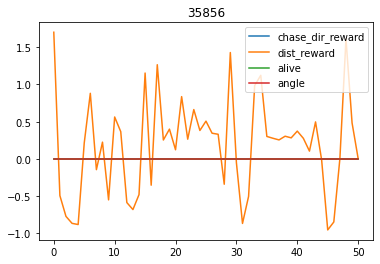

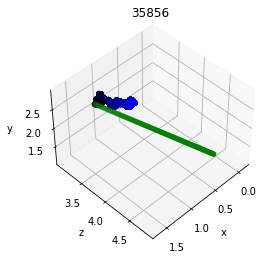

| train | E: 0 | S: 35856 | R: 0.0000 | D: 120.0 s | BR: 0.3053 | ALOSS: -6.9033 | CLOSS: 6.3999 | TLOSS: 0.0061 | TVAL: 0.0296 | AENT: -3.7920
| eval  | E: 1027 | S: 35856 | R: 9.3855
| train | E: 1028 | S: 35856 | R: 32.0748 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1029 | S: 35907 | R: 35.5716 | D: 235.4 s | BR: 0.2816 | ALOSS: -7.2562 | CLOSS: 5.9707 | TLOSS: 0.0089 | TVAL: 0.0293 | AENT: -3.6977
| train | E: 1030 | S: 35918 | R: -7.0121 | D: 27.5 s | BR: 0.2419 | ALOSS: -8.1102 | CLOSS: 6.2839 | TLOSS: -0.0005 | TVAL: 0.0291 | AENT: -4.0186
| train | E: 1031 | S: 35969 | R: 33.1388 | D: 121.7 s | BR: 0.2986 | ALOSS: -7.6272 | CLOSS: 6.5439 | TLOSS: 0.0028 | TVAL: 0.0291 | AENT: -3.9036
| train | E: 1032 | S: 36020 | R: 17.4438 | D: 121.0 s | BR: 0.3061 | ALOSS: -8.0538 | CLOSS: 7.1805 | TLOSS: 0.0046 | TVAL: 0.0289 | AENT: -3.8418
| train | E: 1033 | S: 36071 | R: -22.0758 | D: 121.7 s | BR: 0.3022 | ALOSS: 

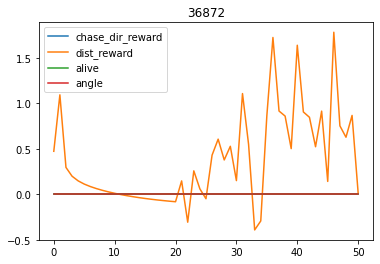

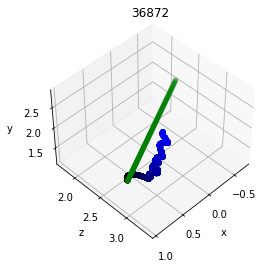

| train | E: 0 | S: 36872 | R: 0.0000 | D: 121.8 s | BR: 0.3079 | ALOSS: -7.5147 | CLOSS: 5.9773 | TLOSS: 0.0017 | TVAL: 0.0281 | AENT: -3.9378
| eval  | E: 1051 | S: 36872 | R: 19.1143
| train | E: 1052 | S: 36872 | R: 16.1240 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1053 | S: 36923 | R: 34.9307 | D: 233.9 s | BR: 0.3235 | ALOSS: -8.3181 | CLOSS: 6.4237 | TLOSS: -0.0012 | TVAL: 0.0281 | AENT: -4.0417
| train | E: 1054 | S: 36974 | R: 30.3826 | D: 121.5 s | BR: 0.2922 | ALOSS: -7.2800 | CLOSS: 6.5046 | TLOSS: -0.0031 | TVAL: 0.0281 | AENT: -4.1086
| train | E: 1055 | S: 37025 | R: -3.4246 | D: 120.5 s | BR: 0.2985 | ALOSS: -6.8232 | CLOSS: 6.3745 | TLOSS: 0.0006 | TVAL: 0.0282 | AENT: -3.9778
| train | E: 1056 | S: 37076 | R: 35.8093 | D: 120.9 s | BR: 0.2976 | ALOSS: -6.9335 | CLOSS: 6.3453 | TLOSS: -0.0028 | TVAL: 0.0283 | AENT: -4.1006
| train | E: 1057 | S: 37083 | R: 8.7886 | D: 19.7 s | BR: 0.3324 | ALOSS:

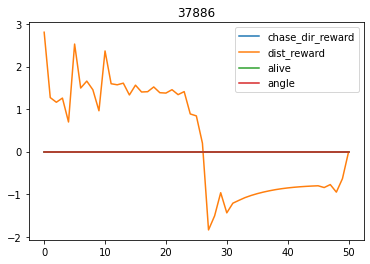

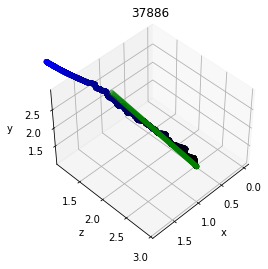

| train | E: 0 | S: 37886 | R: 0.0000 | D: 119.6 s | BR: 0.2834 | ALOSS: -6.8159 | CLOSS: 6.6352 | TLOSS: 0.0076 | TVAL: 0.0281 | AENT: -3.7297
| eval  | E: 1074 | S: 37886 | R: 15.5615
| train | E: 1075 | S: 37886 | R: -0.1821 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1076 | S: 37897 | R: 3.4610 | D: 145.8 s | BR: 0.3077 | ALOSS: -6.6270 | CLOSS: 5.9027 | TLOSS: 0.0099 | TVAL: 0.0280 | AENT: -3.6463
| train | E: 1077 | S: 37916 | R: 28.5433 | D: 48.3 s | BR: 0.2947 | ALOSS: -6.9649 | CLOSS: 6.6494 | TLOSS: 0.0088 | TVAL: 0.0279 | AENT: -3.6829
| train | E: 1078 | S: 37934 | R: -4.6269 | D: 44.3 s | BR: 0.3236 | ALOSS: -7.6893 | CLOSS: 5.9097 | TLOSS: 0.0085 | TVAL: 0.0277 | AENT: -3.6948
| train | E: 1079 | S: 37985 | R: -5.4548 | D: 125.7 s | BR: 0.2828 | ALOSS: -6.2939 | CLOSS: 6.4781 | TLOSS: 0.0060 | TVAL: 0.0276 | AENT: -3.7824
| train | E: 1080 | S: 38001 | R: 16.5128 | D: 41.0 s | BR: 0.2930 | ALOSS: -6.0

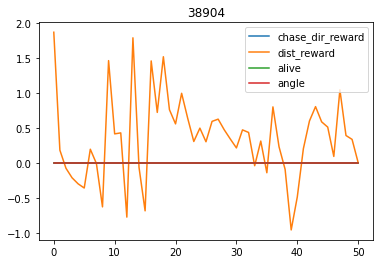

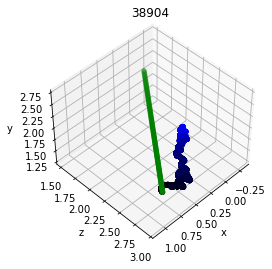

| train | E: 0 | S: 38904 | R: 0.0000 | D: 120.7 s | BR: 0.3038 | ALOSS: -6.3117 | CLOSS: 6.3722 | TLOSS: -0.0033 | TVAL: 0.0276 | AENT: -4.1182
| eval  | E: 1099 | S: 38904 | R: 18.3554
| train | E: 1100 | S: 38904 | R: 13.7014 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1101 | S: 38912 | R: 0.0215 | D: 134.3 s | BR: 0.3110 | ALOSS: -7.0418 | CLOSS: 4.4139 | TLOSS: -0.0025 | TVAL: 0.0277 | AENT: -4.0894
| train | E: 1102 | S: 38963 | R: 32.8877 | D: 124.9 s | BR: 0.3129 | ALOSS: -6.7577 | CLOSS: 6.3503 | TLOSS: -0.0052 | TVAL: 0.0278 | AENT: -4.1883
| train | E: 1103 | S: 39014 | R: 32.8824 | D: 123.8 s | BR: 0.2906 | ALOSS: -7.6642 | CLOSS: 6.2777 | TLOSS: -0.0037 | TVAL: 0.0279 | AENT: -4.1346
| train | E: 1104 | S: 39065 | R: 16.9765 | D: 120.4 s | BR: 0.3014 | ALOSS: -8.1792 | CLOSS: 7.4458 | TLOSS: 0.0013 | TVAL: 0.0280 | AENT: -3.9544
| train | E: 1105 | S: 39116 | R: 38.4538 | D: 125.2 s | BR: 0.2951 | ALOS

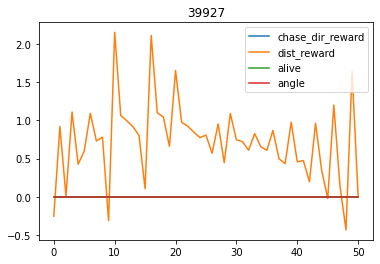

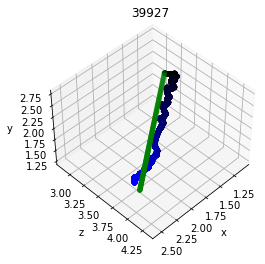

| train | E: 0 | S: 39927 | R: 0.0000 | D: 120.3 s | BR: 0.3072 | ALOSS: -7.2574 | CLOSS: 7.0234 | TLOSS: 0.0084 | TVAL: 0.0284 | AENT: -3.7044
| eval  | E: 1122 | S: 39927 | R: 36.9841
| train | E: 1123 | S: 39927 | R: 26.3258 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1124 | S: 39978 | R: 27.5185 | D: 234.6 s | BR: 0.3105 | ALOSS: -7.2681 | CLOSS: 6.6235 | TLOSS: -0.0043 | TVAL: 0.0282 | AENT: -4.1512
| train | E: 1125 | S: 40029 | R: 35.5918 | D: 122.1 s | BR: 0.2966 | ALOSS: -6.9975 | CLOSS: 7.3852 | TLOSS: 0.0053 | TVAL: 0.0283 | AENT: -3.8134
| train | E: 1126 | S: 40080 | R: 29.2445 | D: 121.3 s | BR: 0.3117 | ALOSS: -7.2239 | CLOSS: 6.4666 | TLOSS: -0.0057 | TVAL: 0.0282 | AENT: -4.2011
| train | E: 1127 | S: 40131 | R: 26.0900 | D: 121.4 s | BR: 0.3056 | ALOSS: -6.9798 | CLOSS: 6.4050 | TLOSS: 0.0031 | TVAL: 0.0284 | AENT: -3.8897
| train | E: 1128 | S: 40182 | R: 31.3993 | D: 121.7 s | BR: 0.3108 | ALOSS

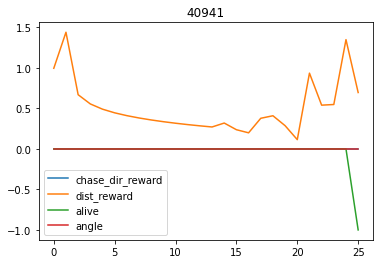

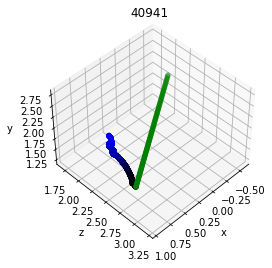

| train | E: 0 | S: 40941 | R: 0.0000 | D: 121.2 s | BR: 0.3168 | ALOSS: -7.1156 | CLOSS: 7.6334 | TLOSS: -0.0064 | TVAL: 0.0278 | AENT: -4.2292
| eval  | E: 1150 | S: 40941 | R: 12.2760
| train | E: 1151 | S: 40941 | R: 10.7193 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1152 | S: 40992 | R: 27.7357 | D: 185.4 s | BR: 0.3141 | ALOSS: -5.7551 | CLOSS: 5.7708 | TLOSS: 0.0062 | TVAL: 0.0279 | AENT: -3.7796
| train | E: 1153 | S: 41012 | R: 2.1820 | D: 49.7 s | BR: 0.3186 | ALOSS: -6.8096 | CLOSS: 5.8852 | TLOSS: -0.0033 | TVAL: 0.0278 | AENT: -4.1175
| train | E: 1154 | S: 41018 | R: 5.9869 | D: 18.3 s | BR: 0.3347 | ALOSS: -7.5068 | CLOSS: 4.7010 | TLOSS: -0.0038 | TVAL: 0.0278 | AENT: -4.1374
| train | E: 1155 | S: 41029 | R: -9.9024 | D: 28.1 s | BR: 0.3624 | ALOSS: -8.0611 | CLOSS: 6.2816 | TLOSS: -0.0013 | TVAL: 0.0278 | AENT: -4.0465
| train | E: 1156 | S: 41053 | R: -1.5478 | D: 59.6 s | BR: 0.2989 | ALOSS: -6

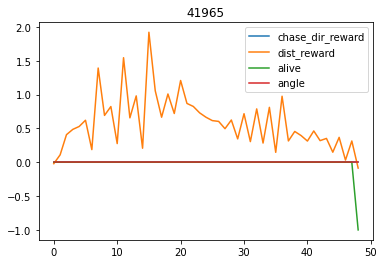

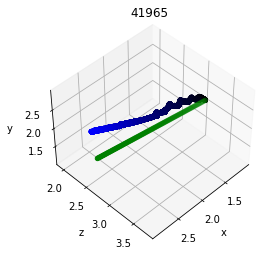

| train | E: 0 | S: 41965 | R: 0.0000 | D: 119.8 s | BR: 0.3165 | ALOSS: -7.9890 | CLOSS: 6.6889 | TLOSS: -0.0108 | TVAL: 0.0277 | AENT: -4.3883
| eval  | E: 1178 | S: 41965 | R: 27.6720
| train | E: 1179 | S: 41965 | R: 9.1661 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1180 | S: 42016 | R: 32.3683 | D: 252.7 s | BR: 0.3114 | ALOSS: -7.4622 | CLOSS: 6.5216 | TLOSS: 0.0053 | TVAL: 0.0279 | AENT: -3.8088
| train | E: 1181 | S: 42067 | R: 34.7994 | D: 124.2 s | BR: 0.3211 | ALOSS: -7.3140 | CLOSS: 6.6843 | TLOSS: 0.0037 | TVAL: 0.0277 | AENT: -3.8671
| train | E: 1182 | S: 42118 | R: 33.6585 | D: 120.4 s | BR: 0.3192 | ALOSS: -7.7364 | CLOSS: 6.6226 | TLOSS: -0.0020 | TVAL: 0.0276 | AENT: -4.0719
| train | E: 1183 | S: 42169 | R: 30.0409 | D: 130.7 s | BR: 0.3145 | ALOSS: -5.1760 | CLOSS: 6.4774 | TLOSS: -0.0010 | TVAL: 0.0278 | AENT: -4.0351
| train | E: 1184 | S: 42203 | R: 4.4243 | D: 90.5 s | BR: 0.3022 | ALOSS: 

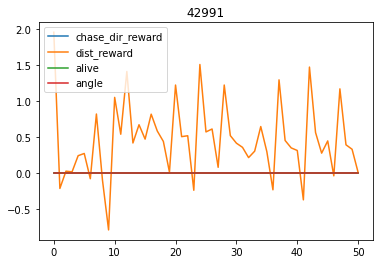

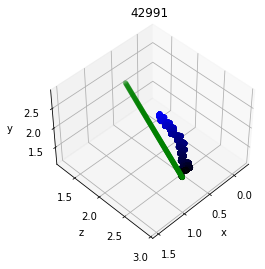

| train | E: 0 | S: 42991 | R: 0.0000 | D: 120.8 s | BR: 0.3454 | ALOSS: -7.7980 | CLOSS: 6.3829 | TLOSS: 0.0042 | TVAL: 0.0275 | AENT: -3.8475
| eval  | E: 1203 | S: 42991 | R: 23.6056
| train | E: 1204 | S: 42991 | R: 31.2997 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1205 | S: 43042 | R: 21.9825 | D: 239.5 s | BR: 0.3066 | ALOSS: -5.7879 | CLOSS: 6.0900 | TLOSS: 0.0007 | TVAL: 0.0274 | AENT: -3.9754
| train | E: 1206 | S: 43093 | R: 32.2115 | D: 126.5 s | BR: 0.3285 | ALOSS: -6.7309 | CLOSS: 6.1048 | TLOSS: -0.0061 | TVAL: 0.0274 | AENT: -4.2237
| train | E: 1207 | S: 43112 | R: 14.2096 | D: 47.4 s | BR: 0.3206 | ALOSS: -8.2260 | CLOSS: 7.4217 | TLOSS: -0.0032 | TVAL: 0.0276 | AENT: -4.1149
| train | E: 1208 | S: 43118 | R: 1.1543 | D: 18.5 s | BR: 0.3410 | ALOSS: -9.8374 | CLOSS: 4.0245 | TLOSS: -0.0125 | TVAL: 0.0276 | AENT: -4.4519
| train | E: 1209 | S: 43125 | R: -5.8537 | D: 20.3 s | BR: 0.2935 | ALOSS: -

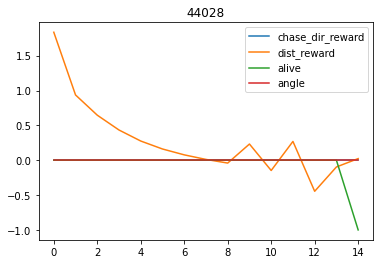

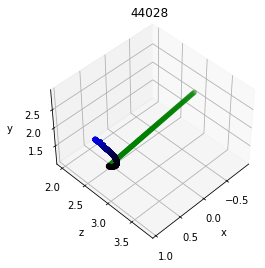

| train | E: 0 | S: 44028 | R: 0.0000 | D: 122.3 s | BR: 0.3147 | ALOSS: -6.9893 | CLOSS: 7.3044 | TLOSS: -0.0023 | TVAL: 0.0287 | AENT: -4.0789
| eval  | E: 1230 | S: 44028 | R: 3.1688
| train | E: 1231 | S: 44028 | R: 35.4299 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1232 | S: 44079 | R: 32.0600 | D: 156.4 s | BR: 0.3180 | ALOSS: -7.1219 | CLOSS: 6.3344 | TLOSS: -0.0018 | TVAL: 0.0288 | AENT: -4.0636
| train | E: 1233 | S: 44091 | R: -4.3471 | D: 31.5 s | BR: 0.3763 | ALOSS: -6.8520 | CLOSS: 6.4570 | TLOSS: 0.0099 | TVAL: 0.0288 | AENT: -3.6560
| train | E: 1234 | S: 44142 | R: 11.5192 | D: 121.8 s | BR: 0.3172 | ALOSS: -8.3290 | CLOSS: 6.8370 | TLOSS: -0.0001 | TVAL: 0.0287 | AENT: -4.0021
| train | E: 1235 | S: 44158 | R: 6.4921 | D: 39.2 s | BR: 0.3383 | ALOSS: -5.1791 | CLOSS: 5.9046 | TLOSS: -0.0066 | TVAL: 0.0287 | AENT: -4.2307
| train | E: 1236 | S: 44178 | R: 8.9289 | D: 48.6 s | BR: 0.3168 | ALOSS: -6

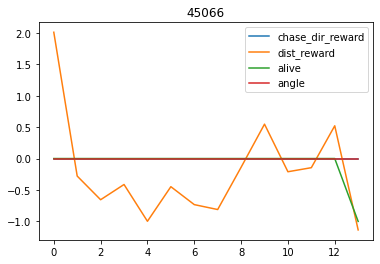

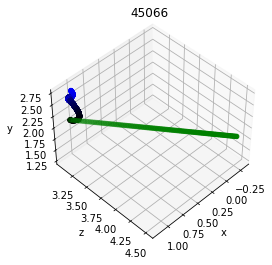

| train | E: 0 | S: 45066 | R: 0.0000 | D: 101.8 s | BR: 0.3394 | ALOSS: -8.3042 | CLOSS: 5.9443 | TLOSS: -0.0043 | TVAL: 0.0288 | AENT: -4.1484
| eval  | E: 1257 | S: 45066 | R: -3.8890
| train | E: 1258 | S: 45066 | R: 20.4401 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1259 | S: 45117 | R: 30.0333 | D: 156.5 s | BR: 0.3471 | ALOSS: -7.2039 | CLOSS: 5.5172 | TLOSS: -0.0060 | TVAL: 0.0290 | AENT: -4.2066
| train | E: 1260 | S: 45151 | R: -29.1004 | D: 81.0 s | BR: 0.3201 | ALOSS: -7.3511 | CLOSS: 7.1748 | TLOSS: 0.0001 | TVAL: 0.0291 | AENT: -3.9964
| train | E: 1261 | S: 45176 | R: 10.0039 | D: 61.0 s | BR: 0.3413 | ALOSS: -7.0304 | CLOSS: 6.7302 | TLOSS: -0.0071 | TVAL: 0.0292 | AENT: -4.2423
| train | E: 1262 | S: 45189 | R: -4.2466 | D: 33.7 s | BR: 0.3329 | ALOSS: -7.9766 | CLOSS: 5.5808 | TLOSS: -0.0092 | TVAL: 0.0293 | AENT: -4.3155
| train | E: 1263 | S: 45207 | R: 14.0957 | D: 43.9 s | BR: 0.3571 | ALOSS:

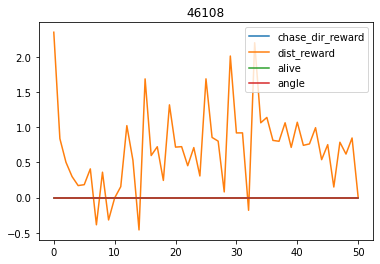

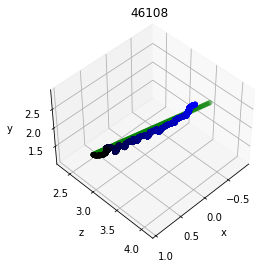

| train | E: 0 | S: 46108 | R: 0.0000 | D: 124.6 s | BR: 0.3465 | ALOSS: -8.5818 | CLOSS: 7.0348 | TLOSS: 0.0044 | TVAL: 0.0301 | AENT: -3.8532
| eval  | E: 1284 | S: 46108 | R: 35.2268
| train | E: 1285 | S: 46108 | R: 32.8467 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1286 | S: 46159 | R: 36.8717 | D: 234.2 s | BR: 0.3339 | ALOSS: -6.8460 | CLOSS: 7.5767 | TLOSS: -0.0018 | TVAL: 0.0299 | AENT: -4.0592
| train | E: 1287 | S: 46209 | R: 28.6435 | D: 123.0 s | BR: 0.3406 | ALOSS: -6.9614 | CLOSS: 6.5528 | TLOSS: 0.0071 | TVAL: 0.0299 | AENT: -3.7628
| train | E: 1288 | S: 46221 | R: 4.7129 | D: 30.8 s | BR: 0.3476 | ALOSS: -6.5887 | CLOSS: 6.3633 | TLOSS: 0.0032 | TVAL: 0.0297 | AENT: -3.8919
| train | E: 1289 | S: 46248 | R: 15.2886 | D: 65.0 s | BR: 0.3349 | ALOSS: -8.5775 | CLOSS: 5.5437 | TLOSS: -0.0062 | TVAL: 0.0297 | AENT: -4.2097
| train | E: 1290 | S: 46299 | R: 10.5148 | D: 120.6 s | BR: 0.3409 | ALOSS: -

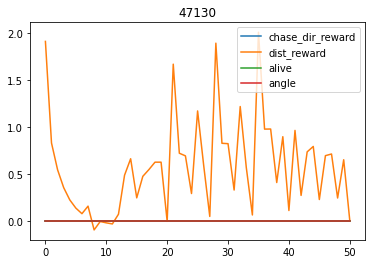

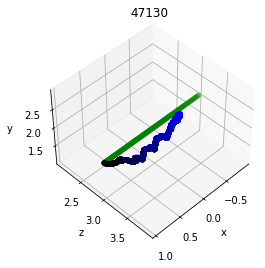

| train | E: 0 | S: 47130 | R: 0.0000 | D: 131.4 s | BR: 0.3342 | ALOSS: -6.9450 | CLOSS: 6.4698 | TLOSS: 0.0013 | TVAL: 0.0306 | AENT: -3.9576
| eval  | E: 1312 | S: 47130 | R: 29.4367
| train | E: 1313 | S: 47130 | R: 26.3666 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1314 | S: 47181 | R: 1.0303 | D: 233.9 s | BR: 0.3451 | ALOSS: -7.4326 | CLOSS: 6.6678 | TLOSS: 0.0013 | TVAL: 0.0306 | AENT: -3.9586
| train | E: 1315 | S: 47232 | R: -23.1218 | D: 119.7 s | BR: 0.3373 | ALOSS: -7.4285 | CLOSS: 6.0852 | TLOSS: -0.0006 | TVAL: 0.0305 | AENT: -4.0187
| train | E: 1316 | S: 47283 | R: -15.0511 | D: 120.8 s | BR: 0.3482 | ALOSS: -7.2851 | CLOSS: 6.3287 | TLOSS: -0.0056 | TVAL: 0.0307 | AENT: -4.1846
| train | E: 1317 | S: 47334 | R: 31.6312 | D: 120.2 s | BR: 0.3563 | ALOSS: -9.2086 | CLOSS: 6.6750 | TLOSS: 0.0043 | TVAL: 0.0308 | AENT: -3.8607
| train | E: 1318 | S: 47385 | R: 32.8531 | D: 120.0 s | BR: 0.3559 | ALOS

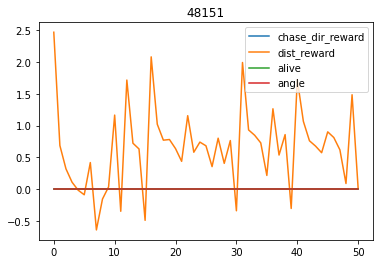

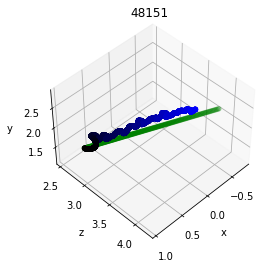

| train | E: 0 | S: 48151 | R: 0.0000 | D: 120.5 s | BR: 0.3614 | ALOSS: -8.0147 | CLOSS: 6.2503 | TLOSS: 0.0111 | TVAL: 0.0311 | AENT: -3.6448
| eval  | E: 1339 | S: 48151 | R: 33.1489
| train | E: 1340 | S: 48151 | R: 30.2945 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1341 | S: 48202 | R: 33.2622 | D: 234.6 s | BR: 0.3401 | ALOSS: -7.7071 | CLOSS: 5.8704 | TLOSS: 0.0057 | TVAL: 0.0308 | AENT: -3.8150
| train | E: 1342 | S: 48253 | R: 35.3239 | D: 125.0 s | BR: 0.3356 | ALOSS: -7.0991 | CLOSS: 6.6872 | TLOSS: 0.0021 | TVAL: 0.0306 | AENT: -3.9320
| train | E: 1343 | S: 48304 | R: 25.4139 | D: 120.2 s | BR: 0.3559 | ALOSS: -7.4892 | CLOSS: 6.5232 | TLOSS: 0.0021 | TVAL: 0.0306 | AENT: -3.9309
| train | E: 1344 | S: 48355 | R: -1.9016 | D: 121.6 s | BR: 0.3582 | ALOSS: -7.6724 | CLOSS: 6.6216 | TLOSS: 0.0010 | TVAL: 0.0304 | AENT: -3.9673
| train | E: 1345 | S: 48406 | R: 31.1485 | D: 119.6 s | BR: 0.3381 | ALOSS: 

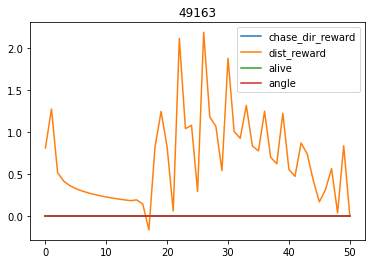

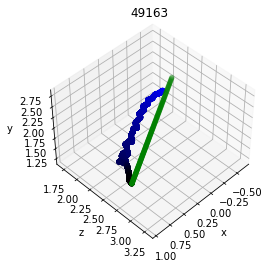

| train | E: 0 | S: 49163 | R: 0.0000 | D: 119.7 s | BR: 0.3522 | ALOSS: -7.8342 | CLOSS: 6.0760 | TLOSS: -0.0005 | TVAL: 0.0302 | AENT: -4.0153
| eval  | E: 1366 | S: 49163 | R: 33.8183
| train | E: 1367 | S: 49163 | R: 27.3252 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1368 | S: 49214 | R: 33.2232 | D: 236.9 s | BR: 0.3326 | ALOSS: -7.3382 | CLOSS: 5.4133 | TLOSS: -0.0056 | TVAL: 0.0303 | AENT: -4.1845
| train | E: 1369 | S: 49265 | R: 31.3829 | D: 120.2 s | BR: 0.3457 | ALOSS: -8.1285 | CLOSS: 6.4347 | TLOSS: 0.0027 | TVAL: 0.0305 | AENT: -3.9127
| train | E: 1370 | S: 49272 | R: -1.0218 | D: 20.4 s | BR: 0.3697 | ALOSS: -8.2379 | CLOSS: 8.3152 | TLOSS: 0.0027 | TVAL: 0.0304 | AENT: -3.9107
| train | E: 1371 | S: 49291 | R: 2.1170 | D: 48.1 s | BR: 0.3563 | ALOSS: -8.5769 | CLOSS: 7.4060 | TLOSS: -0.0108 | TVAL: 0.0304 | AENT: -4.3543
| train | E: 1372 | S: 49342 | R: 14.4380 | D: 119.9 s | BR: 0.3470 | ALOSS: 

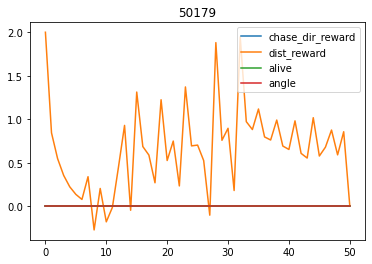

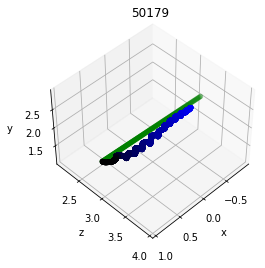

| train | E: 0 | S: 50179 | R: 0.0000 | D: 44.7 s | BR: 0.3610 | ALOSS: -6.3234 | CLOSS: 5.3443 | TLOSS: 0.0004 | TVAL: 0.0320 | AENT: -3.9870
| eval  | E: 1392 | S: 50179 | R: 33.7372
| train | E: 1393 | S: 50179 | R: -10.4251 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1394 | S: 50230 | R: 18.1812 | D: 233.7 s | BR: 0.3409 | ALOSS: -7.4581 | CLOSS: 6.9031 | TLOSS: -0.0067 | TVAL: 0.0321 | AENT: -4.2097
| train | E: 1395 | S: 50262 | R: 27.1242 | D: 79.6 s | BR: 0.3548 | ALOSS: -6.9862 | CLOSS: 6.6013 | TLOSS: 0.0019 | TVAL: 0.0322 | AENT: -3.9424
| train | E: 1396 | S: 50288 | R: 20.3751 | D: 62.9 s | BR: 0.3483 | ALOSS: -7.0437 | CLOSS: 6.5440 | TLOSS: -0.0025 | TVAL: 0.0322 | AENT: -4.0770
| train | E: 1397 | S: 50339 | R: 31.3038 | D: 120.4 s | BR: 0.3435 | ALOSS: -7.8583 | CLOSS: 6.4643 | TLOSS: -0.0031 | TVAL: 0.0324 | AENT: -4.0961
| train | E: 1398 | S: 50355 | R: -0.0181 | D: 41.3 s | BR: 0.3518 | ALOSS: 

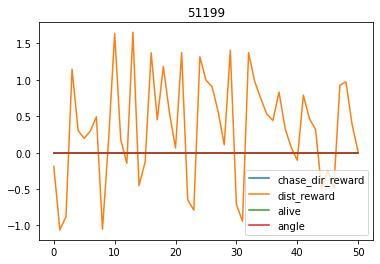

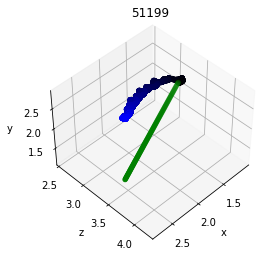

| train | E: 0 | S: 51199 | R: 0.0000 | D: 123.6 s | BR: 0.3439 | ALOSS: -7.8008 | CLOSS: 6.9244 | TLOSS: 0.0036 | TVAL: 0.0322 | AENT: -3.8877
| eval  | E: 1417 | S: 51199 | R: 17.2111
| train | E: 1418 | S: 51199 | R: 36.4100 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1419 | S: 51239 | R: -11.7401 | D: 209.2 s | BR: 0.3409 | ALOSS: -6.0669 | CLOSS: 6.3818 | TLOSS: 0.0045 | TVAL: 0.0320 | AENT: -3.8589
| train | E: 1420 | S: 51254 | R: 0.4069 | D: 37.5 s | BR: 0.3585 | ALOSS: -7.0551 | CLOSS: 7.4231 | TLOSS: -0.0001 | TVAL: 0.0319 | AENT: -4.0024
| train | E: 1421 | S: 51305 | R: 33.6916 | D: 120.8 s | BR: 0.3573 | ALOSS: -7.2842 | CLOSS: 5.8625 | TLOSS: 0.0031 | TVAL: 0.0319 | AENT: -3.9026
| train | E: 1422 | S: 51356 | R: 34.1555 | D: 119.7 s | BR: 0.3511 | ALOSS: -7.7156 | CLOSS: 6.7136 | TLOSS: 0.0017 | TVAL: 0.0318 | AENT: -3.9455
| train | E: 1423 | S: 51407 | R: 33.4919 | D: 120.2 s | BR: 0.3517 | ALOSS: 

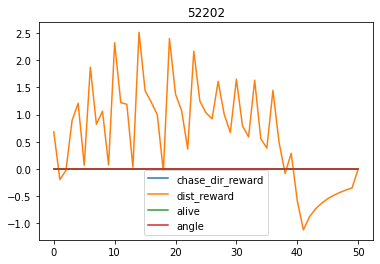

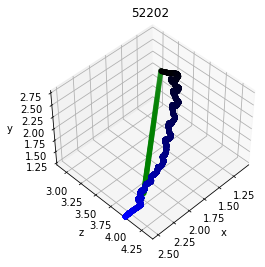

| train | E: 0 | S: 52202 | R: 0.0000 | D: 31.2 s | BR: 0.3717 | ALOSS: -6.6227 | CLOSS: 7.2229 | TLOSS: -0.0059 | TVAL: 0.0321 | AENT: -4.1829
| eval  | E: 1444 | S: 52202 | R: 32.7885
| train | E: 1445 | S: 52202 | R: 2.4927 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1446 | S: 52253 | R: 20.2161 | D: 234.8 s | BR: 0.3664 | ALOSS: -6.0518 | CLOSS: 8.1856 | TLOSS: -0.0033 | TVAL: 0.0322 | AENT: -4.1011
| train | E: 1447 | S: 52268 | R: 16.0026 | D: 36.1 s | BR: 0.3577 | ALOSS: -6.3350 | CLOSS: 8.0305 | TLOSS: -0.0041 | TVAL: 0.0323 | AENT: -4.1256
| train | E: 1448 | S: 52276 | R: 2.1039 | D: 20.4 s | BR: 0.3536 | ALOSS: -6.2709 | CLOSS: 11.0694 | TLOSS: -0.0058 | TVAL: 0.0323 | AENT: -4.1806
| train | E: 1449 | S: 52327 | R: 26.8734 | D: 119.5 s | BR: 0.3495 | ALOSS: -5.6491 | CLOSS: 8.0236 | TLOSS: -0.0029 | TVAL: 0.0324 | AENT: -4.0885
| train | E: 1450 | S: 52378 | R: 31.0892 | D: 119.8 s | BR: 0.3717 | ALOSS:

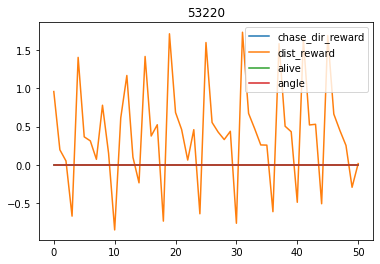

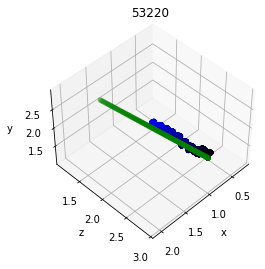

| train | E: 0 | S: 53220 | R: 0.0000 | D: 124.1 s | BR: 0.3775 | ALOSS: -8.1596 | CLOSS: 6.2335 | TLOSS: -0.0061 | TVAL: 0.0321 | AENT: -4.1908
| eval  | E: 1471 | S: 53220 | R: 21.0484
| train | E: 1472 | S: 53220 | R: 37.2908 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1473 | S: 53271 | R: 37.5431 | D: 237.8 s | BR: 0.3651 | ALOSS: -6.2691 | CLOSS: 6.6957 | TLOSS: -0.0009 | TVAL: 0.0324 | AENT: -4.0277
| train | E: 1474 | S: 53289 | R: -5.9143 | D: 44.6 s | BR: 0.3631 | ALOSS: -6.5033 | CLOSS: 5.9573 | TLOSS: 0.0082 | TVAL: 0.0324 | AENT: -3.7486
| train | E: 1475 | S: 53340 | R: 14.0493 | D: 123.4 s | BR: 0.3678 | ALOSS: -8.3569 | CLOSS: 6.1707 | TLOSS: 0.0018 | TVAL: 0.0323 | AENT: -3.9450
| train | E: 1476 | S: 53348 | R: 2.6868 | D: 21.6 s | BR: 0.3578 | ALOSS: -9.4260 | CLOSS: 6.2265 | TLOSS: -0.0022 | TVAL: 0.0322 | AENT: -4.0695
| train | E: 1477 | S: 53361 | R: 3.1724 | D: 34.4 s | BR: 0.3452 | ALOSS: -9

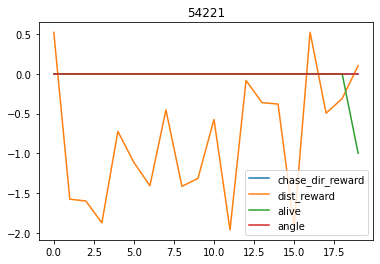

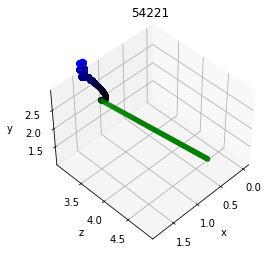

| train | E: 0 | S: 54221 | R: 0.0000 | D: 72.6 s | BR: 0.3689 | ALOSS: -7.6238 | CLOSS: 6.3600 | TLOSS: 0.0113 | TVAL: 0.0330 | AENT: -3.6562
| eval  | E: 1495 | S: 54221 | R: -17.4282
| train | E: 1496 | S: 54221 | R: 18.3444 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1497 | S: 54272 | R: 34.6844 | D: 167.8 s | BR: 0.3603 | ALOSS: -8.2928 | CLOSS: 6.4293 | TLOSS: -0.0034 | TVAL: 0.0328 | AENT: -4.1042
| train | E: 1498 | S: 54280 | R: 0.7048 | D: 22.6 s | BR: 0.3553 | ALOSS: -6.9088 | CLOSS: 6.5189 | TLOSS: -0.0030 | TVAL: 0.0329 | AENT: -4.0901
| train | E: 1499 | S: 54331 | R: 30.8288 | D: 120.4 s | BR: 0.3704 | ALOSS: -6.6152 | CLOSS: 6.1191 | TLOSS: -0.0088 | TVAL: 0.0330 | AENT: -4.2662
| train | E: 1500 | S: 54382 | R: 27.7088 | D: 124.0 s | BR: 0.3675 | ALOSS: -7.0310 | CLOSS: 5.7543 | TLOSS: 0.0013 | TVAL: 0.0333 | AENT: -3.9618
| train | E: 1501 | S: 54390 | R: 5.9279 | D: 20.8 s | BR: 0.3383 | ALOSS: -

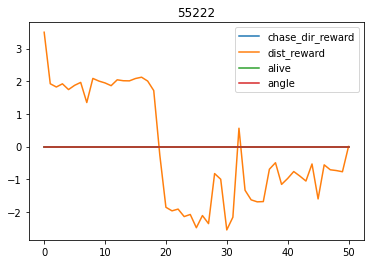

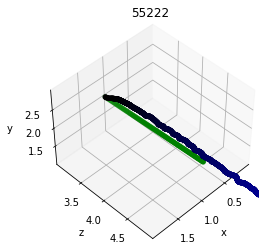

| train | E: 0 | S: 55222 | R: 0.0000 | D: 124.7 s | BR: 0.3885 | ALOSS: -6.9982 | CLOSS: 5.7332 | TLOSS: -0.0004 | TVAL: 0.0331 | AENT: -4.0113
| eval  | E: 1520 | S: 55222 | R: -2.5590
| train | E: 1521 | S: 55222 | R: 30.3855 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1522 | S: 55273 | R: 30.4884 | D: 235.5 s | BR: 0.3915 | ALOSS: -8.5729 | CLOSS: 7.1433 | TLOSS: -0.0059 | TVAL: 0.0332 | AENT: -4.1778
| train | E: 1523 | S: 55294 | R: 8.7752 | D: 51.3 s | BR: 0.3721 | ALOSS: -4.3462 | CLOSS: 7.3011 | TLOSS: 0.0082 | TVAL: 0.0333 | AENT: -3.7540
| train | E: 1524 | S: 55300 | R: 4.4537 | D: 16.2 s | BR: 0.3837 | ALOSS: -4.4442 | CLOSS: 6.8404 | TLOSS: -0.0014 | TVAL: 0.0333 | AENT: -4.0420
| train | E: 1525 | S: 55311 | R: 3.9780 | D: 28.0 s | BR: 0.3734 | ALOSS: -5.0895 | CLOSS: 6.5428 | TLOSS: 0.0052 | TVAL: 0.0332 | AENT: -3.8423
| train | E: 1526 | S: 55339 | R: -8.9848 | D: 68.1 s | BR: 0.3833 | ALOSS: -6.7

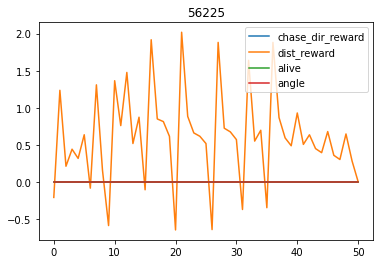

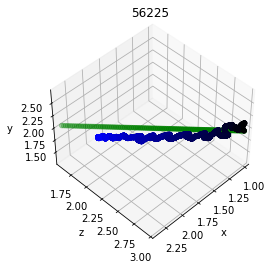

| train | E: 0 | S: 56225 | R: 0.0000 | D: 124.5 s | BR: 0.3810 | ALOSS: -8.1697 | CLOSS: 5.9716 | TLOSS: 0.0013 | TVAL: 0.0331 | AENT: -3.9601
| eval  | E: 1547 | S: 56225 | R: 30.9747
| train | E: 1548 | S: 56225 | R: -20.2610 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1549 | S: 56276 | R: 32.8244 | D: 236.3 s | BR: 0.3640 | ALOSS: -6.5050 | CLOSS: 6.5295 | TLOSS: 0.0051 | TVAL: 0.0330 | AENT: -3.8464
| train | E: 1550 | S: 56327 | R: 36.4396 | D: 120.2 s | BR: 0.3654 | ALOSS: -6.9894 | CLOSS: 6.3655 | TLOSS: 0.0018 | TVAL: 0.0329 | AENT: -3.9460
| train | E: 1551 | S: 56371 | R: 30.6064 | D: 108.6 s | BR: 0.3720 | ALOSS: -7.5256 | CLOSS: 6.7507 | TLOSS: 0.0033 | TVAL: 0.0328 | AENT: -3.9000
| train | E: 1552 | S: 56422 | R: 32.3875 | D: 120.8 s | BR: 0.3758 | ALOSS: -7.7389 | CLOSS: 5.6703 | TLOSS: -0.0029 | TVAL: 0.0327 | AENT: -4.0892
| train | E: 1553 | S: 56437 | R: -9.9061 | D: 38.3 s | BR: 0.3926 | ALOSS:

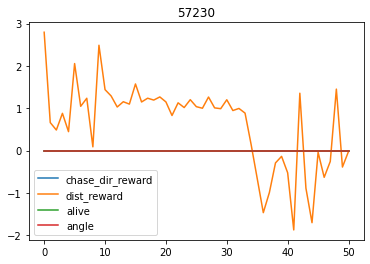

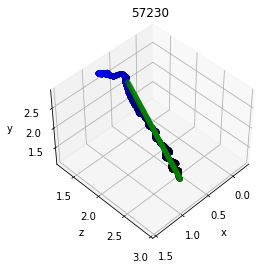

| train | E: 0 | S: 57230 | R: 0.0000 | D: 22.6 s | BR: 0.3816 | ALOSS: -7.2366 | CLOSS: 6.0568 | TLOSS: -0.0030 | TVAL: 0.0325 | AENT: -4.0936
| eval  | E: 1571 | S: 57230 | R: 32.3275
| train | E: 1572 | S: 57230 | R: -0.3141 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1573 | S: 57281 | R: 32.6934 | D: 238.2 s | BR: 0.3591 | ALOSS: -8.0439 | CLOSS: 6.6081 | TLOSS: 0.0013 | TVAL: 0.0325 | AENT: -3.9609
| train | E: 1574 | S: 57332 | R: 36.1588 | D: 124.1 s | BR: 0.3817 | ALOSS: -6.0615 | CLOSS: 5.4572 | TLOSS: 0.0055 | TVAL: 0.0324 | AENT: -3.8312
| train | E: 1575 | S: 57383 | R: 37.7111 | D: 120.3 s | BR: 0.3656 | ALOSS: -6.4464 | CLOSS: 5.4532 | TLOSS: -0.0081 | TVAL: 0.0324 | AENT: -4.2486
| train | E: 1576 | S: 57432 | R: 30.1543 | D: 120.5 s | BR: 0.3865 | ALOSS: -7.5529 | CLOSS: 7.0894 | TLOSS: -0.0020 | TVAL: 0.0326 | AENT: -4.0603
| train | E: 1577 | S: 57483 | R: 14.6307 | D: 120.5 s | BR: 0.3643 | ALOSS

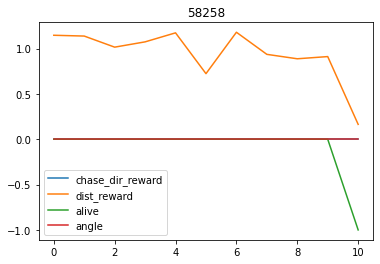

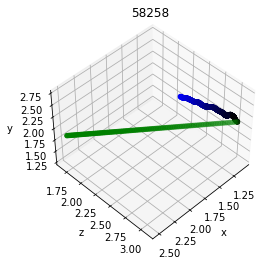

| train | E: 0 | S: 58258 | R: 0.0000 | D: 119.8 s | BR: 0.3969 | ALOSS: -6.0150 | CLOSS: 5.5958 | TLOSS: 0.0027 | TVAL: 0.0332 | AENT: -3.9204
| eval  | E: 1595 | S: 58258 | R: 9.3468
| train | E: 1596 | S: 58258 | R: 2.2039 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1597 | S: 58276 | R: -10.6443 | D: 73.2 s | BR: 0.3853 | ALOSS: -7.6133 | CLOSS: 5.5199 | TLOSS: 0.0001 | TVAL: 0.0332 | AENT: -3.9975
| train | E: 1598 | S: 58327 | R: 34.8528 | D: 119.5 s | BR: 0.3695 | ALOSS: -8.9438 | CLOSS: 5.5800 | TLOSS: -0.0001 | TVAL: 0.0332 | AENT: -4.0022
| train | E: 1599 | S: 58378 | R: 25.5450 | D: 120.3 s | BR: 0.3838 | ALOSS: -7.6346 | CLOSS: 5.8084 | TLOSS: -0.0017 | TVAL: 0.0332 | AENT: -4.0500
| train | E: 1600 | S: 58429 | R: 27.0717 | D: 120.5 s | BR: 0.3833 | ALOSS: -8.7485 | CLOSS: 6.5081 | TLOSS: 0.0043 | TVAL: 0.0333 | AENT: -3.8697
| train | E: 1601 | S: 58469 | R: 8.8798 | D: 96.8 s | BR: 0.3780 | ALOSS: -5

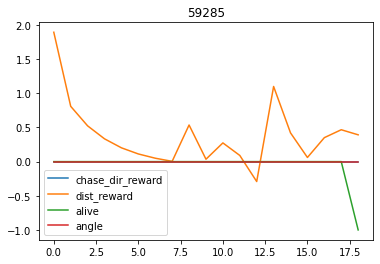

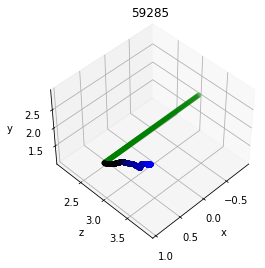

| train | E: 0 | S: 59285 | R: 0.0000 | D: 119.9 s | BR: 0.3913 | ALOSS: -8.0456 | CLOSS: 6.7646 | TLOSS: 0.0059 | TVAL: 0.0333 | AENT: -3.8241
| eval  | E: 1620 | S: 59285 | R: 6.3614
| train | E: 1621 | S: 59285 | R: 29.0997 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1622 | S: 59336 | R: 33.5923 | D: 165.4 s | BR: 0.3698 | ALOSS: -6.5364 | CLOSS: 5.6203 | TLOSS: -0.0010 | TVAL: 0.0332 | AENT: -4.0310
| train | E: 1623 | S: 59355 | R: 29.7935 | D: 46.5 s | BR: 0.3887 | ALOSS: -8.7815 | CLOSS: 5.3405 | TLOSS: 0.0040 | TVAL: 0.0332 | AENT: -3.8795
| train | E: 1624 | S: 59363 | R: 3.3665 | D: 22.6 s | BR: 0.3786 | ALOSS: -9.8065 | CLOSS: 5.5828 | TLOSS: 0.0018 | TVAL: 0.0331 | AENT: -3.9458
| train | E: 1625 | S: 59379 | R: 3.6302 | D: 40.2 s | BR: 0.3824 | ALOSS: -8.7013 | CLOSS: 6.0854 | TLOSS: 0.0024 | TVAL: 0.0331 | AENT: -3.9264
| train | E: 1626 | S: 59430 | R: 17.0257 | D: 119.7 s | BR: 0.3727 | ALOSS: -7.16

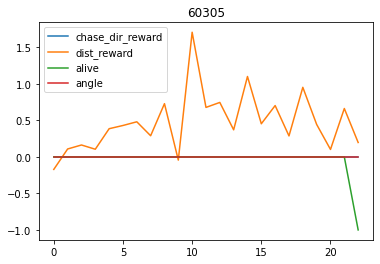

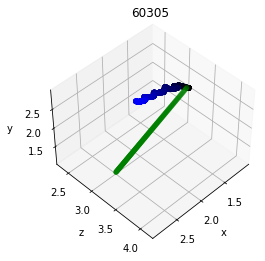

| train | E: 0 | S: 60305 | R: 0.0000 | D: 125.0 s | BR: 0.3896 | ALOSS: -6.7163 | CLOSS: 6.2074 | TLOSS: -0.0048 | TVAL: 0.0341 | AENT: -4.1399
| eval  | E: 1648 | S: 60305 | R: 9.9027
| train | E: 1649 | S: 60305 | R: 31.4744 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1650 | S: 60356 | R: 35.6724 | D: 178.2 s | BR: 0.3880 | ALOSS: -8.9247 | CLOSS: 6.5701 | TLOSS: 0.0095 | TVAL: 0.0342 | AENT: -3.7220
| train | E: 1651 | S: 60407 | R: 35.5585 | D: 121.3 s | BR: 0.3982 | ALOSS: -8.7506 | CLOSS: 7.6025 | TLOSS: -0.0012 | TVAL: 0.0339 | AENT: -4.0344
| train | E: 1652 | S: 60458 | R: 35.7459 | D: 125.2 s | BR: 0.3807 | ALOSS: -5.2556 | CLOSS: 5.8161 | TLOSS: 0.0054 | TVAL: 0.0339 | AENT: -3.8399
| train | E: 1653 | S: 60509 | R: 28.5315 | D: 120.9 s | BR: 0.3843 | ALOSS: -8.0227 | CLOSS: 6.5578 | TLOSS: 0.0033 | TVAL: 0.0337 | AENT: -3.9029
| train | E: 1654 | S: 60560 | R: 37.3518 | D: 124.8 s | BR: 0.3859 | ALOSS:

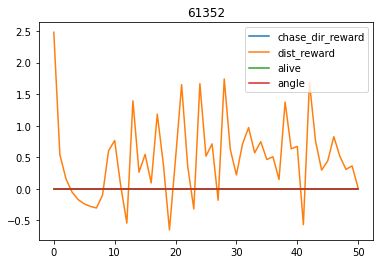

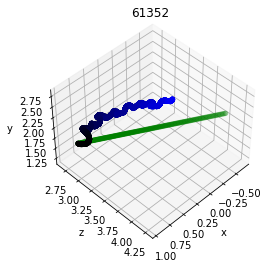

| train | E: 0 | S: 61352 | R: 0.0000 | D: 120.4 s | BR: 0.3824 | ALOSS: -6.8708 | CLOSS: 5.9698 | TLOSS: -0.0051 | TVAL: 0.0327 | AENT: -4.1576
| eval  | E: 1669 | S: 61352 | R: 24.9542
| train | E: 1670 | S: 61352 | R: 31.4613 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1671 | S: 61403 | R: 35.0046 | D: 234.3 s | BR: 0.3940 | ALOSS: -8.6540 | CLOSS: 7.0866 | TLOSS: 0.0082 | TVAL: 0.0327 | AENT: -3.7497
| train | E: 1672 | S: 61454 | R: 36.0838 | D: 120.9 s | BR: 0.4006 | ALOSS: -6.3476 | CLOSS: 6.8914 | TLOSS: -0.0049 | TVAL: 0.0325 | AENT: -4.1503
| train | E: 1673 | S: 61505 | R: 27.3562 | D: 120.4 s | BR: 0.3775 | ALOSS: -5.6494 | CLOSS: 6.8449 | TLOSS: 0.0010 | TVAL: 0.0326 | AENT: -3.9706
| train | E: 1674 | S: 61556 | R: 32.7026 | D: 121.2 s | BR: 0.3994 | ALOSS: -5.3154 | CLOSS: 6.3040 | TLOSS: -0.0029 | TVAL: 0.0326 | AENT: -4.0899
| train | E: 1675 | S: 61575 | R: -3.6244 | D: 46.5 s | BR: 0.3557 | ALOSS

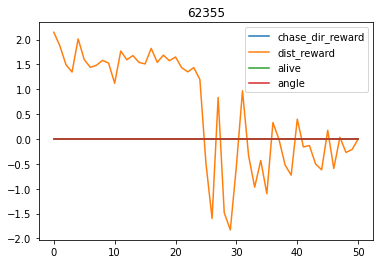

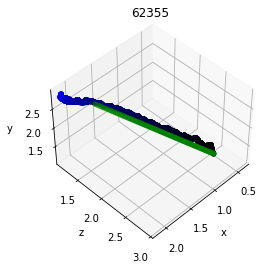

| train | E: 0 | S: 62355 | R: 0.0000 | D: 121.6 s | BR: 0.3739 | ALOSS: -7.9373 | CLOSS: 5.5831 | TLOSS: 0.0090 | TVAL: 0.0334 | AENT: -3.7299
| eval  | E: 1698 | S: 62355 | R: 29.6063
| train | E: 1699 | S: 62355 | R: 15.0257 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1700 | S: 62406 | R: 35.6852 | D: 235.9 s | BR: 0.3828 | ALOSS: -8.7963 | CLOSS: 7.4551 | TLOSS: -0.0094 | TVAL: 0.0333 | AENT: -4.2823
| train | E: 1701 | S: 62457 | R: 2.8603 | D: 121.4 s | BR: 0.3867 | ALOSS: -6.6527 | CLOSS: 6.2317 | TLOSS: -0.0082 | TVAL: 0.0337 | AENT: -4.2440
| train | E: 1702 | S: 62508 | R: 35.0843 | D: 120.6 s | BR: 0.3909 | ALOSS: -8.3850 | CLOSS: 6.2696 | TLOSS: -0.0054 | TVAL: 0.0340 | AENT: -4.1594
| train | E: 1703 | S: 62559 | R: 29.0932 | D: 120.6 s | BR: 0.3706 | ALOSS: -7.2575 | CLOSS: 5.3090 | TLOSS: -0.0025 | TVAL: 0.0341 | AENT: -4.0733
| train | E: 1704 | S: 62570 | R: 0.5491 | D: 26.9 s | BR: 0.4236 | ALOSS:

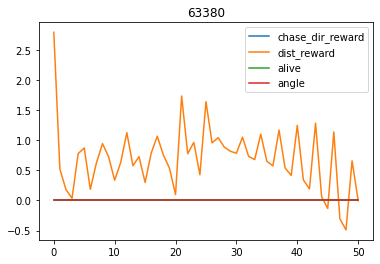

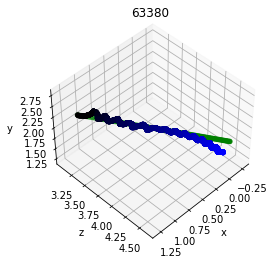

| train | E: 0 | S: 63380 | R: 0.0000 | D: 119.9 s | BR: 0.3814 | ALOSS: -6.2934 | CLOSS: 5.3519 | TLOSS: 0.0036 | TVAL: 0.0353 | AENT: -3.8983
| eval  | E: 1724 | S: 63380 | R: 35.6001
| train | E: 1725 | S: 63380 | R: 34.0199 | D: 00.0 s | BR: 0.0000 | ALOSS: 0.0000 | CLOSS: 0.0000 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.0000
| train | E: 1726 | S: 63431 | R: 14.7933 | D: 233.8 s | BR: 0.3922 | ALOSS: -7.7193 | CLOSS: 5.3128 | TLOSS: -0.0029 | TVAL: 0.0354 | AENT: -4.0817


In [ ]:
ws.run()

## Evaluation and Test

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
from gym_fish.envs import FishEnv
env = gym.make('fish-v0', 
                  gpuId=gpuId,
                       path_json=str(Path("./py_data/jsons/paths/path_ss.json").resolve()),
                        couple_mode= fl.COUPLE_MODE.TWO_WAY,frame_skip=frame_skip,radius=2.0,
                       theta=np.array([-90,90]),action_max=action_max,random_vel=random_vel,
                       fluid_json=fluid_json,wp=1.0,wr=0.0,wa=0.00,
                       rigid_json=rigid_json,
                   )
!./clean_visdata.sh
env.save_data_framRate(save_fluid=False, save_objects=False,framRate = 30)

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
plt.close(fig)
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08

startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
# print(path_position_begin,path_orientation_begin)
# env.rigid_data.skeletons[0].dynamics.setHead(path_position_begin,path_orientation_begin)


env.init_pos = path_position_begin
env.goal_pos = traj.getPose(t+dt).getPosition()
env.goal_dir = traj.getPose(t+dt).getOrientation()
print(env.goal_pos,env.goal_dir)


while not dones:
    obs = env._get_obs()
    if env.rigid_data.rigidWorld.time>40 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    env.stepSave(action,save_objects=True,save_fluid=True)
    if (not np.isfinite(obs).all()):
        print("NAN OBS")
        dones=True
    t = traj.getReferencePose(env.body_xyz)+dt
    env.goal_pos = traj.getPose(t).getPosition()
    env.goal_dir = traj.getPose(t).getOrientation()
#     reward=reward+r
#     infos.append(info)


In [ ]:
plt.close(fig)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.scatter3D(xs=[x[0] for x in env.trajectory_points],
                zs=[x[1] for x in env.trajectory_points],
                ys=[x[2] for x in env.trajectory_points],
                c=[[i/len(env.trajectory_points),0,0] for i in range(len(env.trajectory_points))])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
print(  traj.getPose(t).getPosition(),traj.getPose(t).getOrientation())